<h1><center><span style="color:#6b5b95">Sales Forecasting of Rossmann Stores</span></center></h1>

# Problem Statement
Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks. 

 

As expected, store sales are influenced by many factors, including promotional campaigns, competition, state holidays, seasonality, and locality.

 

With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied. To overcome this problem, the company has hired you as a data scientist to work on the forecasting problem. As part of your job role, you are tasked with building a forecasting model to forecast the daily sales for the next six weeks. To help you with the same, you have been provided with historical sales data for 1,115 Rossmann stores.

In [ ]:
# Uncomment the following code if running in google drive
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#!unzip -q "/content/drive/MyDrive/Sales Forecasting/Dataset.zip" -d Dataset

In [ ]:
### Requirements 
!pip install pandas==1.2.2

In [493]:
# Import section
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller,kpss
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from statsmodels.tsa.vector_ar.vecm import coint_johansen,select_coint_rank #Johansen Cointegration test
from sklearn.metrics import r2_score,mean_absolute_error,median_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf

import warnings
warnings.filterwarnings("ignore")

from pylab import rcParams
import statsmodels.api as sm

# Data Sourcing 

In [2]:
# lets load the dataset into dataframes 
# loading stores dataframe
stores_df = pd.read_csv("Dataset/store.csv")
# loading sales dataframe
sales_df = pd.read_csv("Dataset/train.csv")

### About the Stores Data
Store - an Id that represents the store

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - describes thedistance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb, May, Aug, Nov" means each round starts in February, May, August, November of any given year for that store

In [3]:
# lets check few store records
stores_df.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

#### Remove other stores data 

In [4]:
# Filter the stores records to information only about the ones we are analysing
stores_df = stores_df[stores_df['Store'].isin([1,3,8,9,13,25,29,31,46])]
stores_df['Store'].value_counts()

1     1
3     1
25    1
8     1
9     1
29    1
13    1
46    1
31    1
Name: Store, dtype: int64

In [5]:
# lets check the data type of columns
stores_df.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [6]:
# lets check for any null values
stores_df.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    2
CompetitionOpenSinceYear     2
Promo2                       0
Promo2SinceWeek              6
Promo2SinceYear              6
PromoInterval                6
dtype: int64

In [7]:
# lets check the value ditribution of CompetitionOpenSinceMonth to impute the null values 
stores_df.CompetitionOpenSinceMonth.value_counts()

9.0     2
7.0     1
4.0     1
8.0     1
10.0    1
12.0    1
Name: CompetitionOpenSinceMonth, dtype: int64

In [8]:
# when there is no competition, hence there wont be any months. So lets impute them with zero
stores_df['CompetitionOpenSinceMonth'].fillna(0,inplace=True)

In [9]:
# lets check the value ditribution of CompetitionOpenSinceYear to impute the null values 
stores_df.CompetitionOpenSinceYear.value_counts()

2008.0    1
2014.0    1
2003.0    1
2000.0    1
2012.0    1
2005.0    1
2006.0    1
Name: CompetitionOpenSinceYear, dtype: int64

In [10]:
# when there is no competition, hence there wont be any years of competition. So lets impute them with zero
stores_df['CompetitionOpenSinceYear'].fillna(0,inplace=True)

In [11]:
# Check null values again
stores_df.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              6
Promo2SinceYear              6
PromoInterval                6
dtype: int64

In [12]:
# Check promo variable when null 
stores_df[stores_df.Promo2SinceWeek.isnull()]

Store StoreType Assortment  CompetitionDistance  \
0       1         c          a               1270.0   
7       8         a          a               7520.0   
8       9         a          c               2030.0   
24     25         c          a                430.0   
28     29         d          c               2170.0   
30     31         d          c               9800.0   

    CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                         9.0                    2008.0       0   
7                        10.0                    2014.0       0   
8                         8.0                    2000.0       0   
24                        4.0                    2003.0       0   
28                        0.0                       0.0       0   
30                        7.0                    2012.0       0   

    Promo2SinceWeek  Promo2SinceYear PromoInterval  
0               NaN              NaN           NaN  
7               NaN              NaN           NaN  
8               NaN              NaN           NaN  
24              NaN              NaN           NaN  
28              NaN              NaN           NaN  
30              NaN              NaN           NaN

In [13]:
# lets check the value ditribution of Promo2 to impute the null values 
stores_df.Promo2.value_counts()

0    6
1    3
Name: Promo2, dtype: int64

In [14]:
# lets check the value ditribution of Promo2SinceWeek to impute the null values 
stores_df.Promo2SinceWeek.value_counts()

14.0    2
45.0    1
Name: Promo2SinceWeek, dtype: int64

In [15]:
# lets check the value ditribution of PromoInterval to impute the null values 
stores_df.PromoInterval.value_counts()

Jan,Apr,Jul,Oct    2
Feb,May,Aug,Nov    1
Name: PromoInterval, dtype: int64

In [16]:
# since all the values are null, when one of them is null, hence there is no promotion going on during that time. 
# Hence lets impute promo variables with zero
stores_df.Promo2SinceWeek.fillna(0,inplace=True)
stores_df.Promo2SinceYear.fillna(0,inplace=True)
stores_df.PromoInterval.fillna(0,inplace=True)

In [17]:
# check null value distribution
stores_df.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [18]:
# lets check store distribution again
stores_df

Store StoreType Assortment  CompetitionDistance  \
0       1         c          a               1270.0   
2       3         a          a              14130.0   
7       8         a          a               7520.0   
8       9         a          c               2030.0   
12     13         d          a                310.0   
24     25         c          a                430.0   
28     29         d          c               2170.0   
30     31         d          c               9800.0   
45     46         c          a               1200.0   

    CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                         9.0                    2008.0       0   
2                        12.0                    2006.0       1   
7                        10.0                    2014.0       0   
8                         8.0                    2000.0       0   
12                        0.0                       0.0       1   
24                        4.0                    2003.0       0   
28                        0.0                       0.0       0   
30                        7.0                    2012.0       0   
45                        9.0                    2005.0       1   

    Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0               0.0              0.0                0  
2              14.0           2011.0  Jan,Apr,Jul,Oct  
7               0.0              0.0                0  
8               0.0              0.0                0  
12             45.0           2009.0  Feb,May,Aug,Nov  
24              0.0              0.0                0  
28              0.0              0.0                0  
30              0.0              0.0                0  
45             14.0           2011.0  Jan,Apr,Jul,Oct

In [19]:
# Lets convert PromoInterval categorical variable to number to feed to model
stores_df['PromoInterval'].map({0:0,'Jan,Apr,Jul,Oct':1,"Feb,May,Aug,Nov":2})

0     0
2     1
7     0
8     0
12    2
24    0
28    0
30    0
45    1
Name: PromoInterval, dtype: int64

In [20]:
# Lets replace other categorical variables also with numbers
stores_df['StoreType'] = stores_df['StoreType'].map({'a':1,"b":2,"c":3,"d":4})
stores_df['Assortment'] = stores_df['Assortment'].map({'a':1,"b":2,"c":3,"d":4})
stores_df['PromoInterval'] = stores_df['PromoInterval'].map({0:0,'Jan,Apr,Jul,Oct':1,"Feb,May,Aug,Nov":2})
stores_df

Store  StoreType  Assortment  CompetitionDistance  \
0       1          3           1               1270.0   
2       3          1           1              14130.0   
7       8          1           1               7520.0   
8       9          1           3               2030.0   
12     13          4           1                310.0   
24     25          3           1                430.0   
28     29          4           3               2170.0   
30     31          4           3               9800.0   
45     46          3           1               1200.0   

    CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                         9.0                    2008.0       0   
2                        12.0                    2006.0       1   
7                        10.0                    2014.0       0   
8                         8.0                    2000.0       0   
12                        0.0                       0.0       1   
24                        4.0                    2003.0       0   
28                        0.0                       0.0       0   
30                        7.0                    2012.0       0   
45                        9.0                    2005.0       1   

    Promo2SinceWeek  Promo2SinceYear  PromoInterval  
0               0.0              0.0              0  
2              14.0           2011.0              1  
7               0.0              0.0              0  
8               0.0              0.0              0  
12             45.0           2009.0              2  
24              0.0              0.0              0  
28              0.0              0.0              0  
30              0.0              0.0              0  
45             14.0           2011.0              1

### About the Sales data
Store - a unique Id for each store

DayOfWeek - Describes the day of the week (1 - Monday till 7 - Sunday)

Date - Describes the date on the day

Sales - the turnover for any given day (this is what you are forecasting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

In [21]:
# lets check sales df
sales_df.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [22]:
sales_df.shape

(1017209, 9)

In [23]:
sales_df.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [24]:
# Convert date to datetime type format 
sales_df['Date'] = pd.to_datetime(sales_df['Date'],format='%Y-%m-%d')
sales_df['Date'].min(), sales_df['Date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-07-31 00:00:00'))

#### Remove other stores data

In [25]:
# remove other stores sales data
sales_df = sales_df[sales_df['Store'].isin([1,3,8,9,13,25,29,31,46])]
sales_df['Store'].value_counts()

8     942
1     942
9     942
25    942
29    942
3     942
31    942
13    758
46    758
Name: Store, dtype: int64

In [26]:
# Combine both dataframes into single dataframes
sales_df_all = pd.merge(sales_df,stores_df,on=['Store'],how='left')
sales_df_all.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      3          5 2015-07-31   8314        821     1      1            0   
2      8          5 2015-07-31   8492        833     1      1            0   
3      9          5 2015-07-31   8565        687     1      1            0   
4     13          5 2015-07-31   8821        568     1      1            0   

   SchoolHoliday  StoreType  Assortment  CompetitionDistance  \
0              1          3           1               1270.0   
1              1          1           1              14130.0   
2              1          1           1               7520.0   
3              1          1           3               2030.0   
4              0          4           1                310.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       12.0                    2006.0       1   
2                       10.0                    2014.0       0   
3                        8.0                    2000.0       0   
4                        0.0                       0.0       1   

   Promo2SinceWeek  Promo2SinceYear  PromoInterval  
0              0.0              0.0              0  
1             14.0           2011.0              1  
2              0.0              0.0              0  
3              0.0              0.0              0  
4             45.0           2009.0              2

# Data Cleaning

### Check for null values

In [27]:
sales_df_all.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

#### Observation 
No null values found in the sales/train data

## Outlier Detection

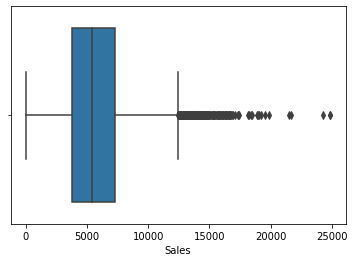

In [28]:
# Plot box plot to check outliers
sns.boxplot(sales_df_all['Sales'])
plt.show()

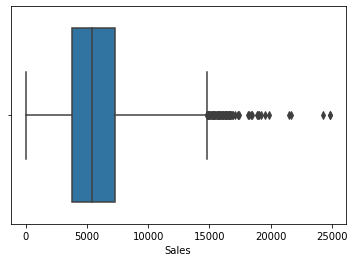

In [29]:
# if we consider 99percentile only
sns.boxplot(sales_df_all['Sales'],whis=[0,99])
plt.show()

In [30]:
# get the cutoff for sales
cutoff_99 = sales_df_all['Sales'].quantile(0.99)
cutoff_99

14810.279999999999

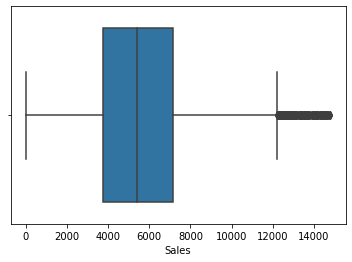

In [31]:
# boxplot after removing outliers above 99 percentile
sns.boxplot(sales_df_all[sales_df_all['Sales']<cutoff_99]['Sales'])
plt.show()

In [32]:
# Get number of records that will be lost if we remove
sales_df_all[sales_df_all['Sales']>cutoff_99].shape[0]

82

### Observation 
- We cannot remove these outliers, as the date frequency will be lost.
- Hence lets replace the values in sales with nan and then linear interpolate the data

### Outlier detection and imputation
lets do the outlier imputation with one store and then replicate to all stores

In [155]:
# consider store 1 data
sales_df_1 =sales_df_all[sales_df_all.Store==1]

In [122]:
# get cutoff 
cutoff_99_1 = sales_df_1['Sales'].quantile(0.99)
cutoff_99_1

7806.240000000001

In [123]:
# Get number of records above 99pc
sales_df_1.loc[sales_df_1['Sales']>cutoff_99_1,'Sales']

Date
2013-05-31    7893
2013-12-16    8277
2013-12-18    7821
2013-12-20    8414
2013-12-21    8043
2013-12-23    9528
2014-12-15    8069
2014-12-20    8367
2014-12-22    9331
2014-12-23    7959
Name: Sales, dtype: int64

In [124]:
# Impute the outliers with NaN, reason being, we cannot delete dataset as time series continuation will be lost
sales_df_1.loc[sales_df_1['Sales']>cutoff_99_1,'Sales'] = np.nan
sales_df_1.isnull().sum()

Store                         0
DayOfWeek                     0
Sales                        10
Customers                     0
Open                          0
Promo                         0
StateHoliday                  0
SchoolHoliday                 0
StoreType                     0
Assortment                    0
CompetitionDistance           0
CompetitionOpenSinceMonth     0
CompetitionOpenSinceYear      0
Promo2                        0
Promo2SinceWeek               0
Promo2SinceYear               0
PromoInterval                 0
year                          0
month                         0
week                          0
CompetitionOpenSince          0
PromoSince                    0
dtype: int64

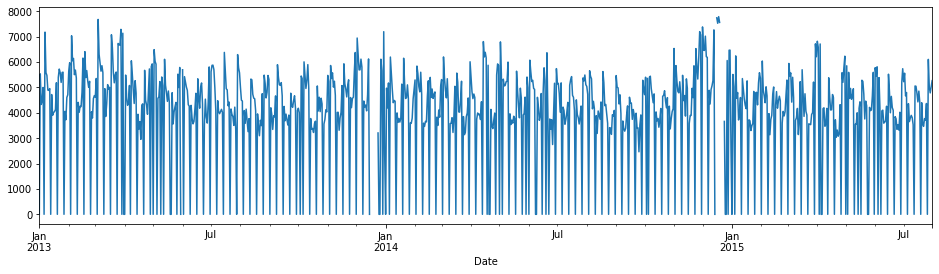

In [125]:
# lets check the missing values in line plot
sales_df_1['Sales'].plot(figsize=(16, 4))
plt.show()

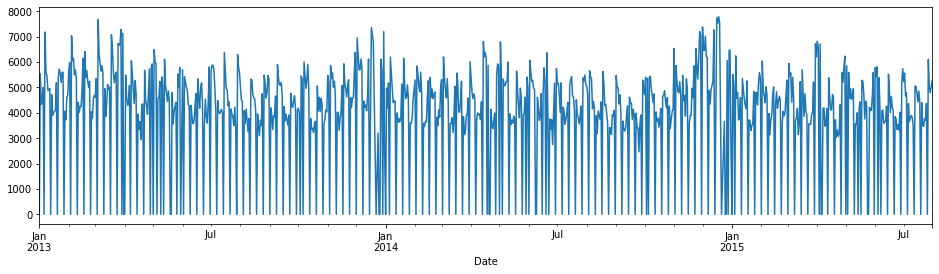

In [126]:
# lets check the missing values in line plot after linear interpolation imputation
sales_df_1['Sales'].interpolate(method='linear').plot(figsize=(16, 4))
plt.show()

In [127]:
# lets linear interpolate the outliers 
sales_df_1['Sales'] = sales_df_1['Sales'].interpolate(method='linear')
sales_df_1['Sales'].isnull().sum()

0

In [46]:
sales_df_all.shape

(8110, 18)

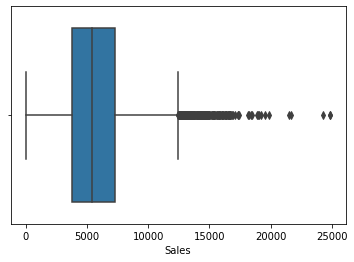

In [53]:
# after linear interpolation,
sns.boxplot(sales_df_all['Sales'])
plt.show()

In [167]:
# lets define a generic function to impute these outliers for other stores also 
def interpolate_outlier(sales):
    cutoff_99 = sales.quantile(0.99)
    sales.loc[sales>cutoff_99] = np.nan
    sales = sales.interpolate(method='linear')
    return sales

In [168]:
# remove outliers for all stores
for i in sales_df_all['Store'].value_counts().index.values:
    sales_df_all[sales_df_all['Store']==i]['Sales'] = interpolate_outlier(sales_df_all[sales_df_all['Store']==i]['Sales'])

In [169]:
sales_df_all.isnull().sum()

Store                        0
DayOfWeek                    0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
year                         0
month                        0
week                         0
CompetitionOpenSince         0
PromoSince                   0
dtype: int64

In [47]:
#sales_df_all = sales_df_all[sales_df_all['Sales']<cutoff_99]
#sales_df_all

### Date indexing

In [28]:
# set date column as index
sales_df_all.set_index("Date",inplace=True)

In [29]:
# sort dataset by date index
sales_df_all.sort_index(inplace=True)

In [30]:
sales_df_all.Store.value_counts()

8     942
1     942
9     942
25    942
29    942
3     942
31    942
13    758
46    758
Name: Store, dtype: int64

# EDA 

## Sales

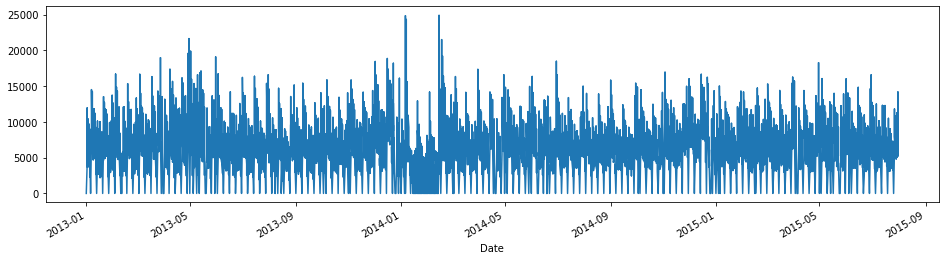

In [31]:
# lets check the line plot for sales
sales_df_all['Sales'].plot(figsize = (16,4))
plt.show()

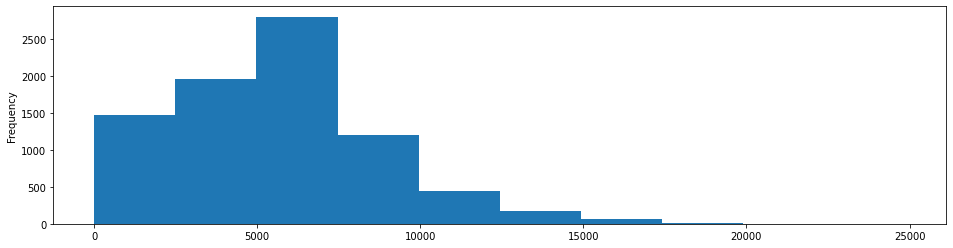

In [32]:
# lets plot histogram to check distribution 
sales_df_all['Sales'].plot.hist(figsize = (16,4))
plt.show()

### Observation 
- we see that there is no trend 
- we also see that variation is almost same 


## Customers
- lets check how customers has impact on Sales

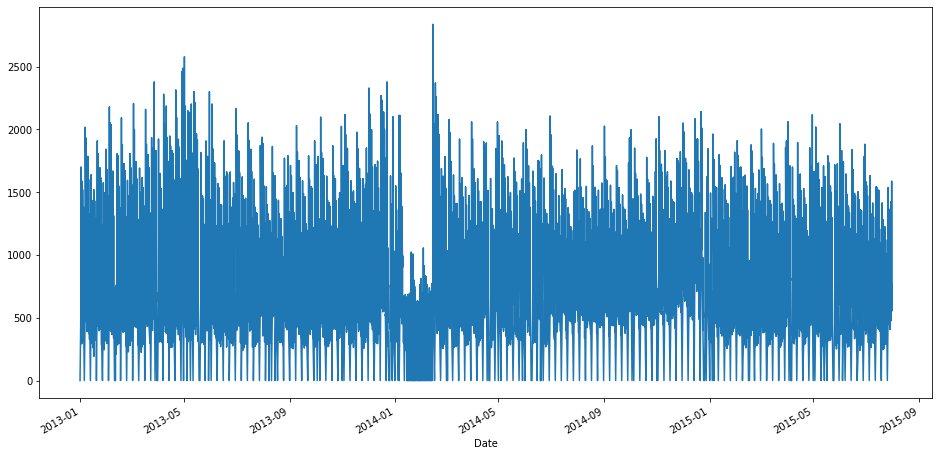

In [33]:
plt.figure(figsize=(16,8))
sales_df_all['Customers'].plot()
plt.show()

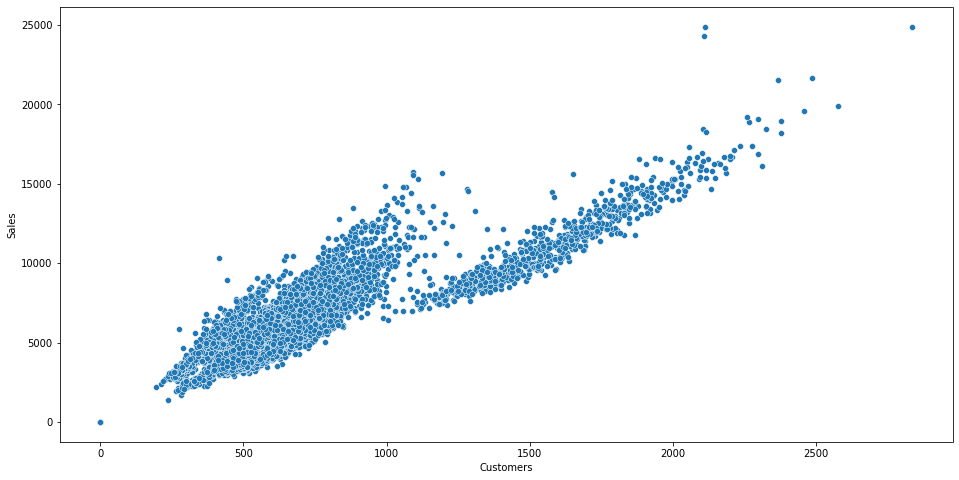

In [34]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=sales_df_all['Customers'],y=sales_df_all['Sales'])
plt.show()

### Observation 
- We can see that as the number of customers increases, the sales also increasing. Hence it has huge impact on Sales.
- Hence there is huge impact of customers on sales and its a endogeneous variable

## Store Open
- lets check how store being open has impact on sales

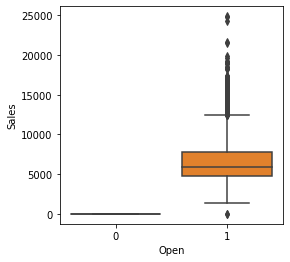

In [35]:
# plot boxplot of Open vs Sales
plt.figure(figsize=(4,4))
sns.boxplot(x=sales_df_all['Open'],y=sales_df_all['Sales'])
plt.show()

### Observation
- When the store is open, the sales are high which makes sense, as nobody would shop when store is closed

## Day, Month, Year 
- lets check how date params has impact on sales 

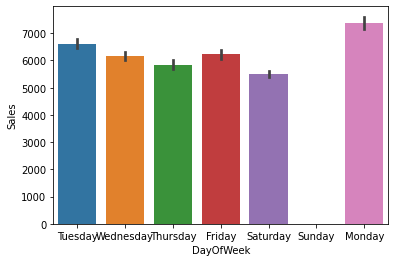

In [36]:
# lets check how day of week is impacting sales
plt.figure(figsize=(12,4))
sns.barplot(x=sales_df_all['DayOfWeek'].map({1:"Monday",2:"Tuesday",3:"Wednesday",4:"Thursday",5:"Friday",6:"Saturday",7:"Sunday"}),y=sales_df_all['Sales'])
plt.show()

### Observation
- We see that sales is high on Monday and weekends its less

In [37]:
sales_df_all.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2013-01-01     46          2      0          0     0      0            a   
2013-01-01      1          2      0          0     0      0            a   
2013-01-01      3          2      0          0     0      0            a   
2013-01-01      8          2      0          0     0      0            a   
2013-01-01     31          2      0          0     0      0            a   

            SchoolHoliday  StoreType  Assortment  CompetitionDistance  \
Date                                                                    
2013-01-01              1          3           1               1200.0   
2013-01-01              1          3           1               1270.0   
2013-01-01              1          1           1              14130.0   
2013-01-01              1          1           1               7520.0   
2013-01-01              1          4           3               9800.0   

            CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
Date                                                                      
2013-01-01                        9.0                    2005.0       1   
2013-01-01                        9.0                    2008.0       0   
2013-01-01                       12.0                    2006.0       1   
2013-01-01                       10.0                    2014.0       0   
2013-01-01                        7.0                    2012.0       0   

            Promo2SinceWeek  Promo2SinceYear  PromoInterval  
Date                                                         
2013-01-01             14.0           2011.0              1  
2013-01-01              0.0              0.0              0  
2013-01-01             14.0           2011.0              1  
2013-01-01              0.0              0.0              0  
2013-01-01              0.0              0.0              0

In [38]:
# lets create new columns from date index like week , year , month
sales_df_all['year'] = sales_df_all.index.year
sales_df_all['month'] = sales_df_all.index.month
sales_df_all['week'] = sales_df_all.index.week

In [39]:
# get average sales monthly
sales_df_all.groupby('month')['Sales'].mean().reset_index()

month        Sales
0       1  4992.702509
1       2  5220.759259
2       3  5422.862605
3       4  5407.532099
4       5  5119.020311
5       6  5340.554321
6       7  5694.037419
7       8  5267.429435
8       9  5241.218750
9      10  5280.187500
10     11  5724.620833
11     12  6415.733871

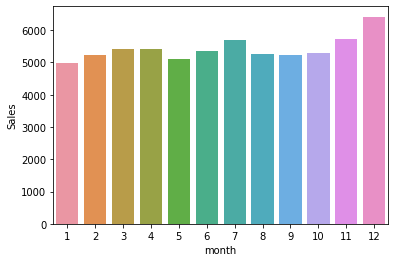

In [40]:
# plot bar plot to visualize
plt.figure(figsize=(12,4))
sns.barplot(data=sales_df_all.groupby('month')['Sales'].mean().reset_index(),x='month',y='Sales')
plt.show()

### Observation 
- We can see that in the month of november and december because of holiday season, the sales are high

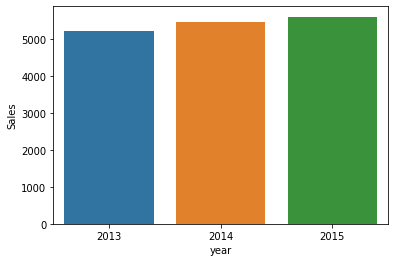

In [41]:
# Check yearly average sales 
plt.figure(figsize=(12,4))
sns.barplot(data=sales_df_all.groupby('year')['Sales'].mean().reset_index(),x='year',y='Sales')
plt.show()

### Observation 
- We can also see that as the year goes by the sales also increased

In [42]:
sales_df_all.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2013-01-01     46          2      0          0     0      0            a   
2013-01-01      1          2      0          0     0      0            a   
2013-01-01      3          2      0          0     0      0            a   
2013-01-01      8          2      0          0     0      0            a   
2013-01-01     31          2      0          0     0      0            a   

            SchoolHoliday  StoreType  Assortment  CompetitionDistance  \
Date                                                                    
2013-01-01              1          3           1               1200.0   
2013-01-01              1          3           1               1270.0   
2013-01-01              1          1           1              14130.0   
2013-01-01              1          1           1               7520.0   
2013-01-01              1          4           3               9800.0   

            CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
Date                                                                      
2013-01-01                        9.0                    2005.0       1   
2013-01-01                        9.0                    2008.0       0   
2013-01-01                       12.0                    2006.0       1   
2013-01-01                       10.0                    2014.0       0   
2013-01-01                        7.0                    2012.0       0   

            Promo2SinceWeek  Promo2SinceYear  PromoInterval  year  month  week  
Date                                                                            
2013-01-01             14.0           2011.0              1  2013      1     1  
2013-01-01              0.0              0.0              0  2013      1     1  
2013-01-01             14.0           2011.0              1  2013      1     1  
2013-01-01              0.0              0.0              0  2013      1     1  
2013-01-01              0.0              0.0              0  2013      1     1

## Competition
- check how competition is affecting sales

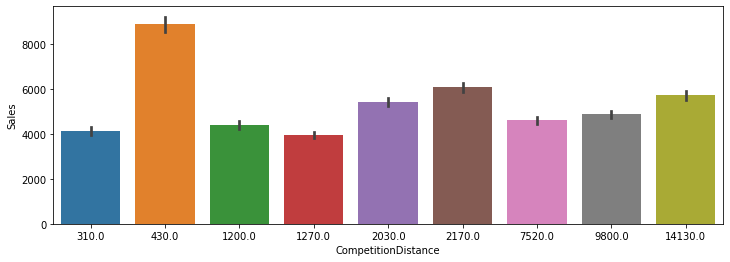

In [43]:
plt.figure(figsize=(12,4))
sns.barplot(x=sales_df_all['CompetitionDistance'],y=sales_df_all['Sales'])
plt.show()

### Observation
- we see that as the for stores within distance of 430 , the sales is high, but there is no correlation of sales and competition as we can see in the graph

In [44]:
# lets convert the CompetitionOpenSinceYear and CompetitionOpenSinceMonth 
# to another column which will tell since how many months competition is happening
sales_df_all[['year','CompetitionOpenSinceYear']].apply(lambda x: 12*(x[0]-x[1]) if x[1]>0 else 0, axis=1) + sales_df_all[['month','CompetitionOpenSinceMonth']].apply(lambda x: x[0]-x[1] if x[1]>0 else 0, axis=1)

Date
2013-01-01     88.0
2013-01-01     52.0
2013-01-01     73.0
2013-01-01    -21.0
2013-01-01      6.0
              ...  
2015-07-31      0.0
2015-07-31    179.0
2015-07-31      9.0
2015-07-31    103.0
2015-07-31     82.0
Length: 8110, dtype: float64

In [45]:
sales_df_all.tail(10)

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-30     13          4   7648        474     1      1            0   
2015-07-31     46          5   7628        775     1      1            0   
2015-07-31     31          5   7248        645     1      1            0   
2015-07-31     29          5   9411        737     1      1            0   
2015-07-31     25          5  14180       1586     1      1            0   
2015-07-31     13          5   8821        568     1      1            0   
2015-07-31      9          5   8565        687     1      1            0   
2015-07-31      8          5   8492        833     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      1          5   5263        555     1      1            0   

            SchoolHoliday  StoreType  Assortment  CompetitionDistance  \
Date                                                                    
2015-07-30              0          4           1                310.0   
2015-07-31              0          3           1               1200.0   
2015-07-31              1          4           3               9800.0   
2015-07-31              1          4           3               2170.0   
2015-07-31              1          3           1                430.0   
2015-07-31              0          4           1                310.0   
2015-07-31              1          1           3               2030.0   
2015-07-31              1          1           1               7520.0   
2015-07-31              1          1           1              14130.0   
2015-07-31              1          3           1               1270.0   

            CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
Date                                                                      
2015-07-30                        0.0                       0.0       1   
2015-07-31                        9.0                    2005.0       1   
2015-07-31                        7.0                    2012.0       0   
2015-07-31                        0.0                       0.0       0   
2015-07-31                        4.0                    2003.0       0   
2015-07-31                        0.0                       0.0       1   
2015-07-31                        8.0                    2000.0       0   
2015-07-31                       10.0                    2014.0       0   
2015-07-31                       12.0                    2006.0       1   
2015-07-31                        9.0                    2008.0       0   

            Promo2SinceWeek  Promo2SinceYear  PromoInterval  year  month  week  
Date                                                                            
2015-07-30             45.0           2009.0              2  2015      7    31  
2015-07-31             14.0           2011.0              1  2015      7    31  
2015-07-31              0.0              0.0              0  2015      7    31  
2015-07-31              0.0              0.0              0  2015      7    31  
2015-07-31              0.0              0.0              0  2015      7    31  
2015-07-31             45.0           2009.0              2  2015      7    31  
2015-07-31              0.0              0.0              0  2015      7    31  
2015-07-31              0.0              0.0              0  2015      7    31  
2015-07-31             14.0           2011.0              1  2015      7    31  
2015-07-31              0.0              0.0              0  2015      7    31

In [46]:
# Get the competition open since in terms of months by differencing year and months
sales_df_all['CompetitionOpenSince'] = sales_df_all[['year','CompetitionOpenSinceYear']].apply(lambda x: 12*(x[0]-x[1]) if x[1]>0 else 0, axis=1) + sales_df_all[['month','CompetitionOpenSinceMonth']].apply(lambda x: x[0]-x[1] if x[1]>0 else 0, axis=1)
# make the records zero where the future competition dates are present
sales_df_all['CompetitionOpenSince'] = sales_df_all['CompetitionOpenSince'].apply(lambda x: x if x>0 else 0)
sales_df_all['CompetitionOpenSince']

Date
2013-01-01     88.0
2013-01-01     52.0
2013-01-01     73.0
2013-01-01      0.0
2013-01-01      6.0
              ...  
2015-07-31      0.0
2015-07-31    179.0
2015-07-31      9.0
2015-07-31    103.0
2015-07-31     82.0
Name: CompetitionOpenSince, Length: 8110, dtype: float64

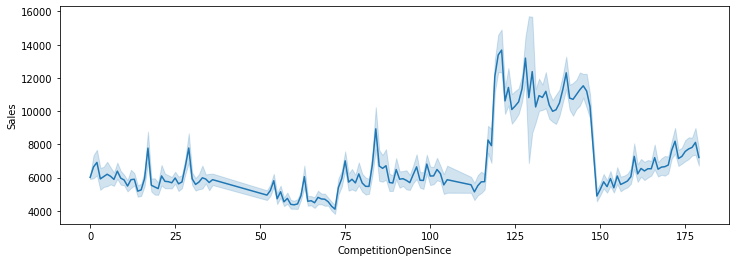

In [47]:
# Check how it has impact on sals
plt.figure(figsize=(12,4))
sns.lineplot(data=sales_df_all[sales_df_all.Open!=0],x='CompetitionOpenSince',y='Sales')
plt.show()

### Observation
- We can see that the more recent competition have higher impact on sales, and older competition have lesser impact. But there is no clear trend as more or less the line plot remain same and little high which have 125months old. 

## Promotion  
- check how promotion is affecting sales

In [48]:
# lets check sales when store is opened only
sales_df_all[sales_df_all['Open']!=0]['Promo2']

Date
2013-01-02    1
2013-01-02    0
2013-01-02    0
2013-01-02    0
2013-01-02    1
             ..
2015-07-31    1
2015-07-31    0
2015-07-31    0
2015-07-31    1
2015-07-31    0
Name: Promo2, Length: 6681, dtype: int64

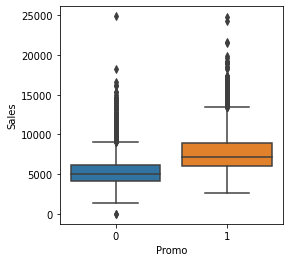

In [49]:
# lets visualise using boxplot
plt.figure(figsize=(4,4))
sns.boxplot(data=sales_df_all[sales_df_all['Open']==1],x='Promo',y='Sales')
plt.show()

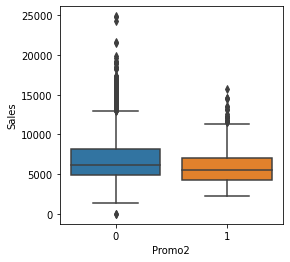

In [50]:
# lets visualise promo2 using boxplot
plt.figure(figsize=(4,4))
sns.boxplot(data=sales_df_all[sales_df_all['Open']==1],x='Promo2',y='Sales')
plt.show()


### Observation
- We can see that promo variable has impact on sales but promo2 doesnt see much impact

In [51]:
# Get the promotion open since in terms of months by differencing year and weeks
sales_df_all['PromoSince'] = sales_df_all[['year','Promo2SinceYear']].apply(lambda x: 12*(x[0]-x[1]) if x[1]>0 else 0, axis=1) + sales_df_all[['week','Promo2SinceWeek']].apply(lambda x: (x[0]-x[1])/4 if x[1]>0 else 0, axis=1)
#sales_df_all['PromoSince'] = 12*(sales_df_all['year']-sales_df_all['Promo2SinceYear']) + (sales_df_all['week']-sales_df_all['Promo2SinceWeek'])/4.0
# make the records zero where the future promotions dates are present
sales_df_all['PromoSince'] = sales_df_all['PromoSince'].apply(lambda x: x if x>0 else 0)
sales_df_all['PromoSince']

Date
2013-01-01    20.75
2013-01-01     0.00
2013-01-01    20.75
2013-01-01     0.00
2013-01-01     0.00
              ...  
2015-07-31    68.50
2015-07-31     0.00
2015-07-31     0.00
2015-07-31    52.25
2015-07-31     0.00
Name: PromoSince, Length: 8110, dtype: float64

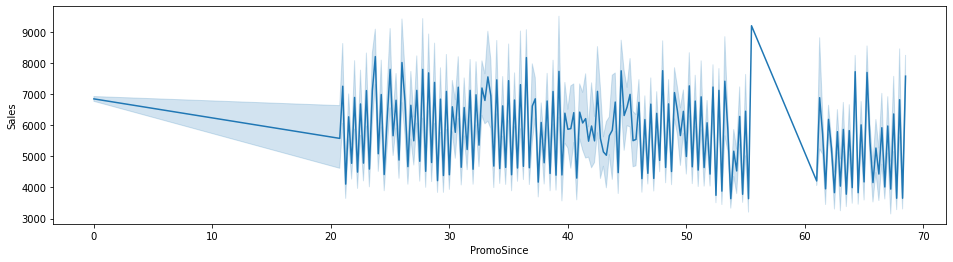

In [52]:
# Check how it has impact on sales
plt.figure(figsize=(16,4))
sns.lineplot(data=sales_df_all[sales_df_all.Open!=0],x='PromoSince',y='Sales')
plt.show()

### Observation 
- The promotion period when it was started has an impact on the sales, but then we dont see any trend or relation to sales.


In [53]:
sales_df_all.dtypes

Store                          int64
DayOfWeek                      int64
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                      int64
Assortment                     int64
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                  int64
year                           int64
month                          int64
week                           int64
CompetitionOpenSince         float64
PromoSince                   float64
dtype: object

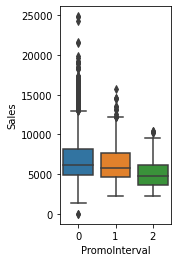

'Jan,Apr,Jul,Oct':1,'Feb,May,Aug,Nov':2


In [54]:
# lets visualise how PromoInterval has impact on sales
plt.figure(figsize=(2,4))
sns.boxplot(data=sales_df_all[sales_df_all.Open!=0],x='PromoInterval',y='Sales')
plt.show()
print("'Jan,Apr,Jul,Oct':1,'Feb,May,Aug,Nov':2")

### Observation 
- We see that promotion interval one which happens in Jan,Apr,Jul,Oct has more impact on sales than the one which happens in Feb,May,Aug,Nov

## Holidays
- impact of holidays on sales

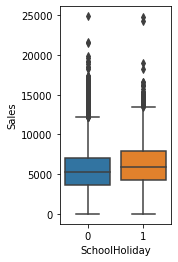

In [55]:
# lets visualise school holiday impact on sales
plt.figure(figsize=(2,4))
sns.boxplot(x=sales_df_all['SchoolHoliday'],y=sales_df_all['Sales'])
plt.show()

In [56]:
# Convert the StateHoliday to string
sales_df_all['StateHoliday'] = sales_df_all['StateHoliday'].astype(str)

In [57]:
# Map the StateHoliday with numbers
sales_df_all['StateHoliday'] = sales_df_all['StateHoliday'].map({'0':0,'a':1,'b':2,'c':3})
sales_df_all['StateHoliday'].value_counts()

0    7861
1     163
2      54
3      32
Name: StateHoliday, dtype: int64

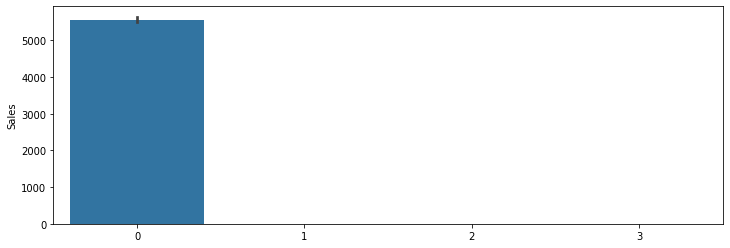

In [58]:
# visualize impact of StateHoliday
plt.figure(figsize=(12,4))
sns.barplot(x=sales_df_all['StateHoliday'].values,y=sales_df_all['Sales'])
plt.show()

### Observation 
- we see that sales are high when there is school holiday but when there is state holiday the sales are zero. which means the shop is also closed when there is state holiday. Hence we can discard this variable

## Assortment and Store type
- check how Assortment and Store type is affecting sales

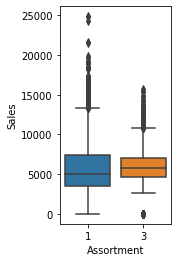

In [59]:
# Lets visualize how assortment has impact on sales
plt.figure(figsize=(2,4))
sns.boxplot(x=sales_df_all['Assortment'],y=sales_df_all['Sales'])
plt.show()

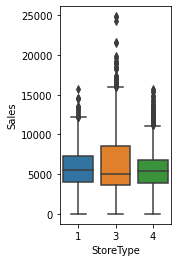

In [60]:
# Lets visualize how Store type has impact on sales
plt.figure(figsize=(2,4))
sns.boxplot(x=sales_df_all['StoreType'],y=sales_df_all['Sales'])
plt.show()

### Observation 
- we dont see much significance of assortment but sales are slightly inclined towards type A
- Also for store type 3 which is C, the sales are slightly more

## Correlation

In [61]:
# prepare correlation matrix of absolute values
corr_matrix = sales_df_all.corr().abs()
corr_matrix

Store  DayOfWeek     Sales  Customers      Open  \
Store                      1.000000   0.000269  0.083952   0.114768  0.007374   
DayOfWeek                  0.000269   1.000000  0.500999   0.421268  0.533098   
Sales                      0.083952   0.500999  1.000000   0.928872  0.721880   
Customers                  0.114768   0.421268  0.928872   1.000000  0.648122   
Open                       0.007374   0.533098  0.721880   0.648122  1.000000   
Promo                      0.001560   0.392922  0.504876   0.352058  0.296402   
StateHoliday               0.003723   0.044569  0.249424   0.223939  0.345520   
SchoolHoliday              0.016671   0.212951  0.096528   0.077816  0.089420   
StoreType                  0.577154   0.000223  0.000864   0.028090  0.005241   
Assortment                 0.270457   0.000236  0.015114   0.152291  0.009474   
CompetitionDistance        0.247016   0.000255  0.043313   0.071498  0.012695   
CompetitionOpenSinceMonth  0.358652   0.000173  0.111519   0.033331  0.009855   
CompetitionOpenSinceYear   0.148881   0.000230  0.025911   0.183601  0.000433   
Promo2                     0.071541   0.000489  0.108269   0.138941  0.002039   
Promo2SinceWeek            0.040276   0.000538  0.131476   0.208854  0.003555   
Promo2SinceYear            0.071633   0.000488  0.108228   0.138850  0.002037   
PromoInterval              0.000966   0.000545  0.128799   0.191843  0.003140   
year                       0.007865   0.001971  0.044366   0.004220  0.004400   
month                      0.040340   0.005275  0.062778   0.054945  0.007546   
week                       0.039062   0.005307  0.065563   0.057168  0.013334   
CompetitionOpenSince       0.051430   0.000077  0.178328   0.266459  0.011938   
PromoSince                 0.023433   0.000377  0.112365   0.164639  0.002916   

                              Promo  StateHoliday  SchoolHoliday  StoreType  \
Store                      0.001560      0.003723       0.016671   0.577154   
DayOfWeek                  0.392922      0.044569       0.212951   0.000223   
Sales                      0.504876      0.249424       0.096528   0.000864   
Customers                  0.352058      0.223939       0.077816   0.028090   
Open                       0.296402      0.345520       0.089420   0.005241   
Promo                      1.000000      0.022342       0.066698   0.001295   
StateHoliday               0.022342      1.000000       0.205014   0.002843   
SchoolHoliday              0.066698      0.205014       1.000000   0.002802   
StoreType                  0.001295      0.002843       0.002802   1.000000   
Assortment                 0.001367      0.003550       0.001647   0.215808   
CompetitionDistance        0.001477      0.006294       0.004826   0.407978   
CompetitionOpenSinceMonth  0.001001      0.004571       0.005497   0.730940   
CompetitionOpenSinceYear   0.001336      0.005462       0.006025   0.560683   
Promo2                     0.002835      0.009255       0.012736   0.045590   
Promo2SinceWeek            0.003121      0.009182       0.013960   0.213951   
Promo2SinceYear            0.002834      0.009253       0.012733   0.045825   
PromoInterval              0.003159      0.009649       0.014155   0.123979   
year                       0.024346      0.004837       0.028756   0.006528   
month                      0.012492      0.037928       0.114817   0.033483   
week                       0.000387      0.039584       0.082827   0.032423   
CompetitionOpenSince       0.002640      0.004088       0.010007   0.437902   
PromoSince                 0.000243      0.010164       0.015928   0.035916   

                           Assortment  ...  CompetitionOpenSinceYear  \
Store                        0.270457  ...                  0.148881   
DayOfWeek                    0.000236  ...                  0.000230   
Sales                        0.015114  ...                  0.025911   
Customers                    0.152291  ...                  

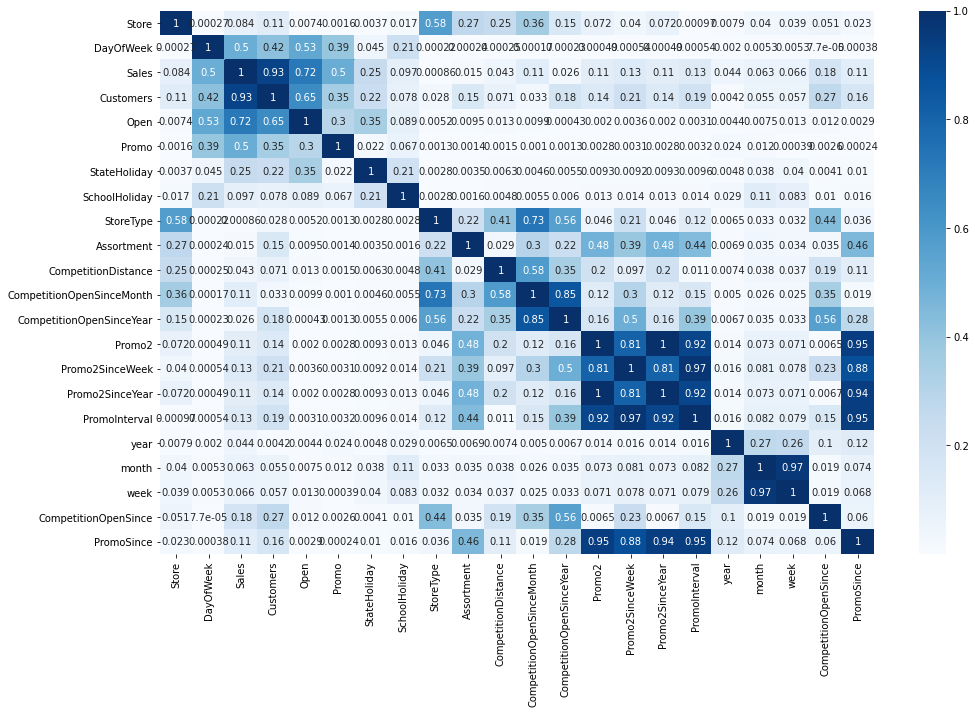

In [62]:
# print heatmap
plt.figure(figsize=(16,10))
sns.heatmap(corr_matrix,cmap='Blues',annot=True)
plt.show()

In [63]:
# sort correlation matrix and get top highly correlated variables
high_correlated_variables_all = corr_matrix['Sales'].sort_values(ascending=False)
high_correlated_variables_all

Sales                        1.000000
Customers                    0.928872
Open                         0.721880
Promo                        0.504876
DayOfWeek                    0.500999
StateHoliday                 0.249424
CompetitionOpenSince         0.178328
Promo2SinceWeek              0.131476
PromoInterval                0.128799
PromoSince                   0.112365
CompetitionOpenSinceMonth    0.111519
Promo2                       0.108269
Promo2SinceYear              0.108228
SchoolHoliday                0.096528
Store                        0.083952
week                         0.065563
month                        0.062778
year                         0.044366
CompetitionDistance          0.043313
CompetitionOpenSinceYear     0.025911
Assortment                   0.015114
StoreType                    0.000864
Name: Sales, dtype: float64

### Observation 
- We see a high correlation among the Sales and Customers
- We also see there is correlation between Open, which makes sense as store when open will make sales
- there is high correlation among promotion variables themselves as we can see in correlation heat map. 


# Model Building and Evaluation
This will have the following analysis 
- Data Sanity Check for forecasting store wise
- Model building
- model evalutation
- forecasting for next 6 weeks

In [88]:
sales_df_all.head()

Store  DayOfWeek  Sales  Customers  Open  Promo  StateHoliday  \
Date                                                                        
2013-01-01     46          2      0          0     0      0             1   
2013-01-01      1          2      0          0     0      0             1   
2013-01-01      3          2      0          0     0      0             1   
2013-01-01      8          2      0          0     0      0             1   
2013-01-01     31          2      0          0     0      0             1   

            SchoolHoliday  StoreType  Assortment  ...  \
Date                                              ...   
2013-01-01              1          3           1  ...   
2013-01-01              1          3           1  ...   
2013-01-01              1          1           1  ...   
2013-01-01              1          1           1  ...   
2013-01-01              1          4           3  ...   

            CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  \
Date                                                            
2013-01-01                    2005.0       1             14.0   
2013-01-01                    2008.0       0              0.0   
2013-01-01                    2006.0       1             14.0   
2013-01-01                    2014.0       0              0.0   
2013-01-01                    2012.0       0              0.0   

            Promo2SinceYear  PromoInterval  year  month  week  \
Date                                                            
2013-01-01           2011.0              1  2013      1     1   
2013-01-01              0.0              0  2013      1     1   
2013-01-01           2011.0              1  2013      1     1   
2013-01-01              0.0              0  2013      1     1   
2013-01-01              0.0              0  2013      1     1   

            CompetitionOpenSince  PromoSince  
Date                                          
2013-01-01                  88.0       20.75  
2013-01-01                  52.0        0.00  
2013-01-01                  73.0       20.75  
2013-01-01                   0.0        0.00  
2013-01-01                   6.0        0.00  

[5 rows x 22 columns]

In [535]:
# prepate different dataframe contain stores 1,3,8,9,13,25,29,31 and 46
sales_df_1 =sales_df_all[sales_df_all.Store==1]
sales_df_3 =sales_df_all[sales_df_all.Store==3]
sales_df_8 =sales_df_all[sales_df_all.Store==8]
sales_df_9 =sales_df_all[sales_df_all.Store==9]
sales_df_13 =sales_df_all[sales_df_all.Store==13]
sales_df_25 =sales_df_all[sales_df_all.Store==25]
sales_df_29 =sales_df_all[sales_df_all.Store==29]
sales_df_31 =sales_df_all[sales_df_all.Store==31]
sales_df_46 =sales_df_all[sales_df_all.Store==46]


## Store 1


In [90]:
sales_df_1.head()

Store  DayOfWeek  Sales  Customers  Open  Promo  StateHoliday  \
Date                                                                        
2013-01-01      1          2      0          0     0      0             1   
2013-01-02      1          3   5530        668     1      0             0   
2013-01-03      1          4   4327        578     1      0             0   
2013-01-04      1          5   4486        619     1      0             0   
2013-01-05      1          6   4997        635     1      0             0   

            SchoolHoliday  StoreType  Assortment  ...  \
Date                                              ...   
2013-01-01              1          3           1  ...   
2013-01-02              1          3           1  ...   
2013-01-03              1          3           1  ...   
2013-01-04              1          3           1  ...   
2013-01-05              1          3           1  ...   

            CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  \
Date                                                            
2013-01-01                    2008.0       0              0.0   
2013-01-02                    2008.0       0              0.0   
2013-01-03                    2008.0       0              0.0   
2013-01-04                    2008.0       0              0.0   
2013-01-05                    2008.0       0              0.0   

            Promo2SinceYear  PromoInterval  year  month  week  \
Date                                                            
2013-01-01              0.0              0  2013      1     1   
2013-01-02              0.0              0  2013      1     1   
2013-01-03              0.0              0  2013      1     1   
2013-01-04              0.0              0  2013      1     1   
2013-01-05              0.0              0  2013      1     1   

            CompetitionOpenSince  PromoSince  
Date                                          
2013-01-01                  52.0         0.0  
2013-01-02                  52.0         0.0  
2013-01-03                  52.0         0.0  
2013-01-04                  52.0         0.0  
2013-01-05                  52.0         0.0  

[5 rows x 22 columns]

### Decomposition
- check the trend and noise in the dataset by additive decomposition

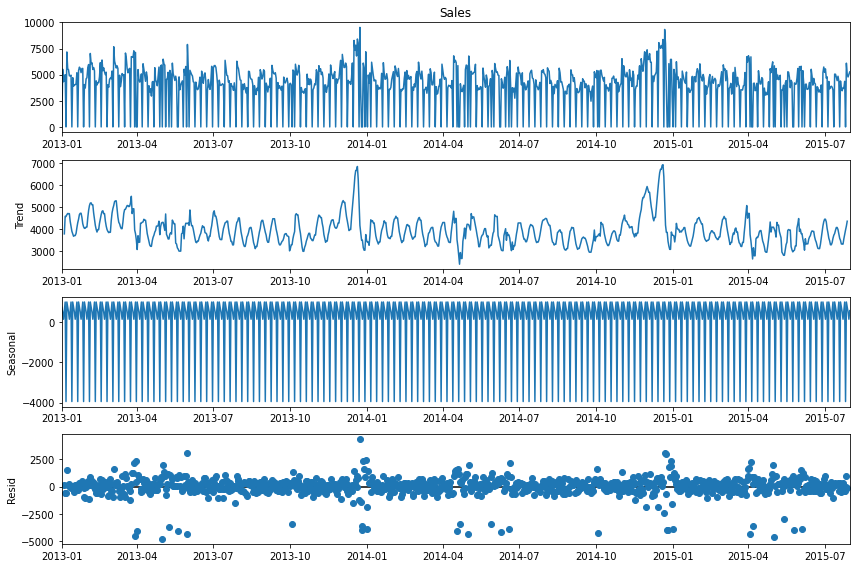

In [190]:
# lets write a common function to decompose the data
def check_decomposition(data):
    rcParams['figure.figsize'] = 12, 8
    decomposition = sm.tsa.seasonal_decompose(data, model='additive') # additive seasonal index
    fig = decomposition.plot()
    plt.show()

check_decomposition(sales_df_1['Sales'])

### Observation
- we see that there is no trend in the store 1 dataset, also we see that there is seasonality in the dataset

### Stationarity Test
- check if data is stationary using ADF Test

In [191]:
def check_stationary(data):
    adf_test = adfuller(data)
    print('ADF Statistic: %f' % adf_test[0])
    print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
    print('p-value: %f' % adf_test[1])
    print('Stationary result:',adf_test[1]<=0.05)
    print("\n")
    print("======="*5)

print("ADF Stationarity Test for Store 1")
check_stationary(sales_df_1['Sales'])

ADF Stationarity Test for Store 1
ADF Statistic: -4.368104
Critical Values @ 0.05: -2.86
p-value: 0.000338
Stationary result: True




### Observation 
- we see that for ADF Test, the p-value is less than 0.05. Hence the series is stationary

In [93]:
sales_df_1.dtypes

Store                          int64
DayOfWeek                      int64
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                   int64
SchoolHoliday                  int64
StoreType                      int64
Assortment                     int64
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                  int64
year                           int64
month                          int64
week                           int64
CompetitionOpenSince         float64
PromoSince                   float64
dtype: object

In [129]:
# lets check for some more variables 
stationarity_checklist = ['DayOfWeek','Open','Promo','Customers','CompetitionOpenSince','PromoSince','month',]

In [130]:
for varname in stationarity_checklist:
    print("Variable Name: ",varname)
    check_stationary(sales_df_1[varname])

Variable Name:  DayOfWeek
ADF Statistic: -0.000000
Critical Values @ 0.05: -2.86
p-value: 0.958532
Stationary result: False


Variable Name:  Open
ADF Statistic: -5.811074
Critical Values @ 0.05: -2.86
p-value: 0.000000
Stationary result: True


Variable Name:  Promo
ADF Statistic: -8.151000
Critical Values @ 0.05: -2.86
p-value: 0.000000
Stationary result: True


Variable Name:  Customers
ADF Statistic: -3.696842
Critical Values @ 0.05: -2.86
p-value: 0.004158
Stationary result: True


Variable Name:  CompetitionOpenSince
ADF Statistic: -0.321936
Critical Values @ 0.05: -2.86
p-value: 0.922340
Stationary result: False


Variable Name:  PromoSince
ADF Statistic: nan
Critical Values @ 0.05: -2.86
p-value: nan
Stationary result: False


Variable Name:  month
ADF Statistic: -2.673526
Critical Values @ 0.05: -2.86
p-value: 0.078733
Stationary result: False




### Observation 
- we see that Open, Promo, Customers are stationary

Variable Name:  DayOfWeek


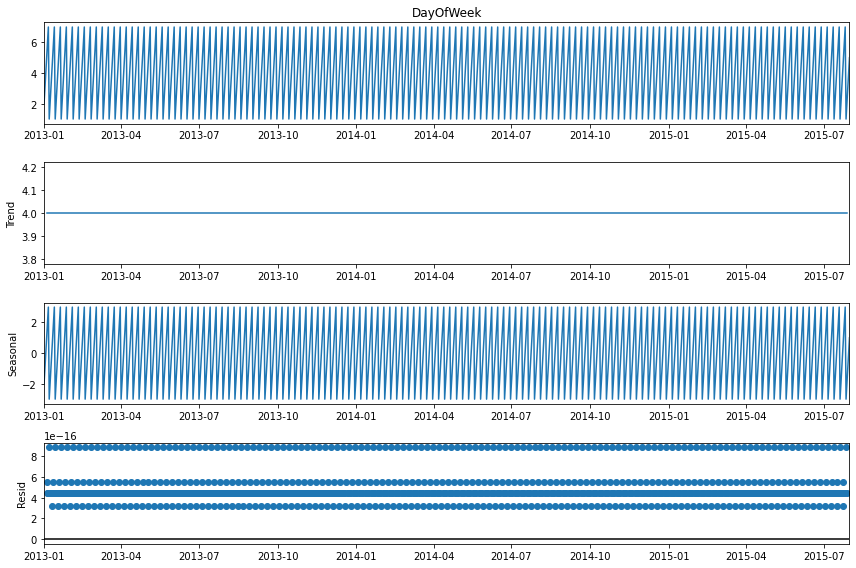

Variable Name:  Open


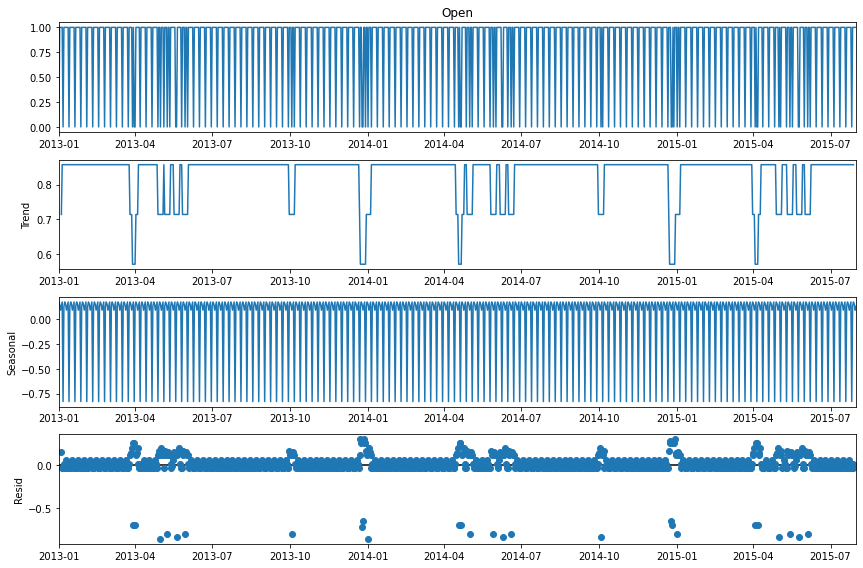

Variable Name:  Promo


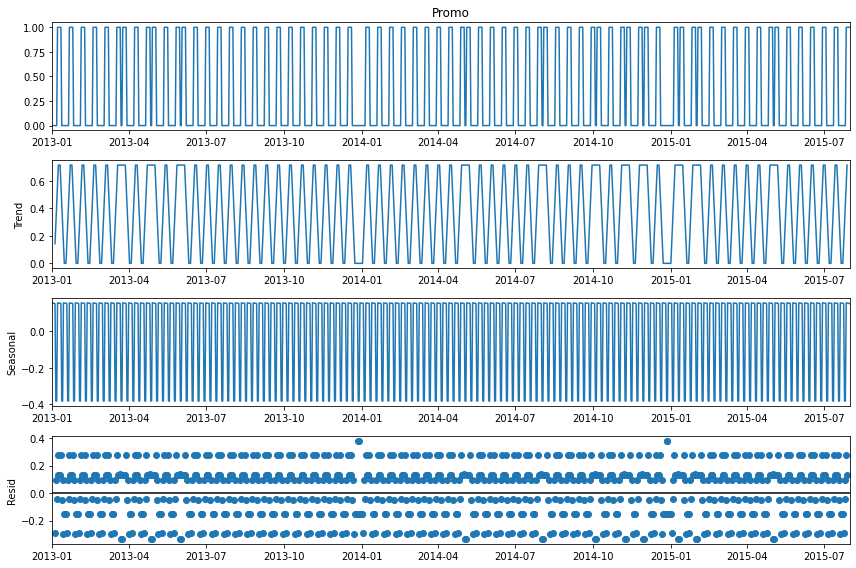

Variable Name:  Customers


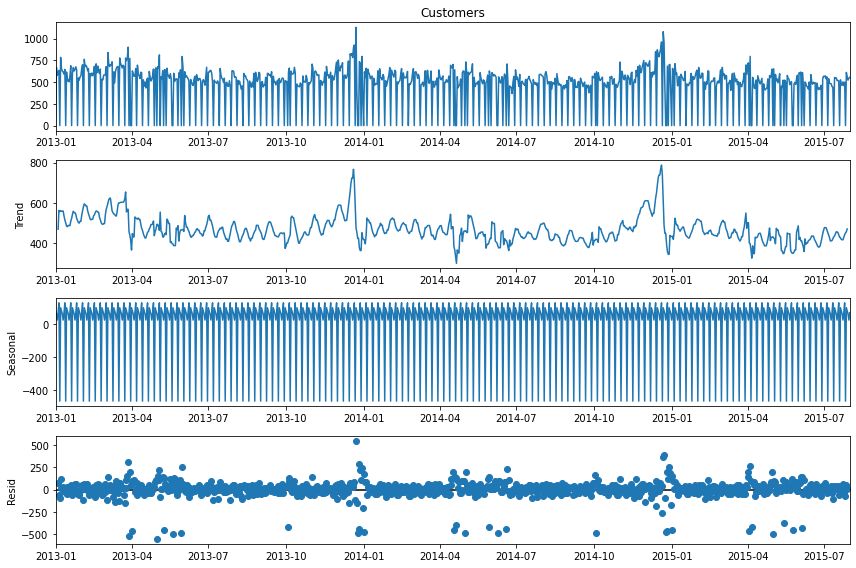

Variable Name:  CompetitionOpenSince


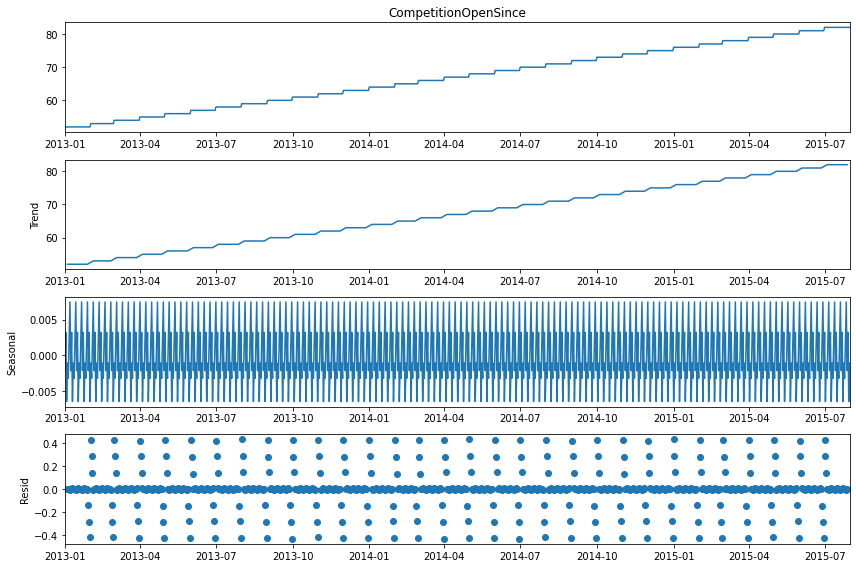

Variable Name:  PromoSince


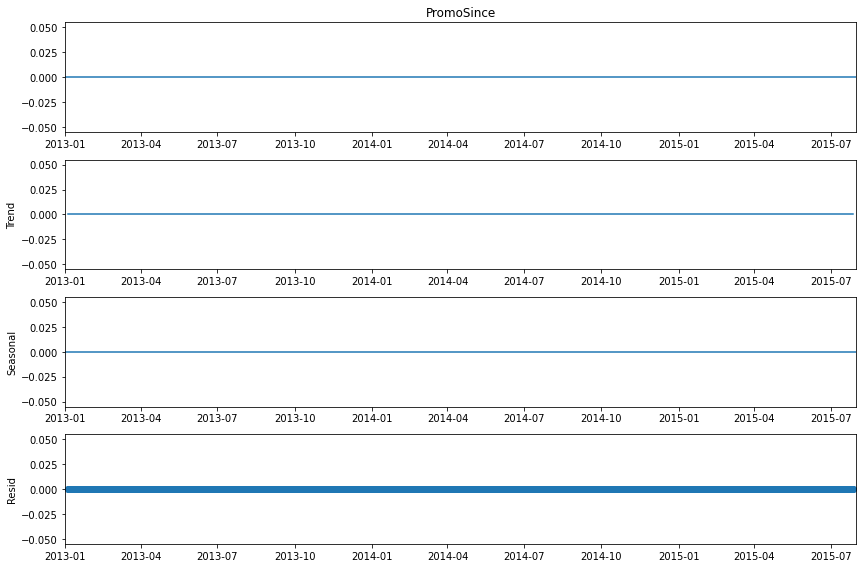

Variable Name:  month


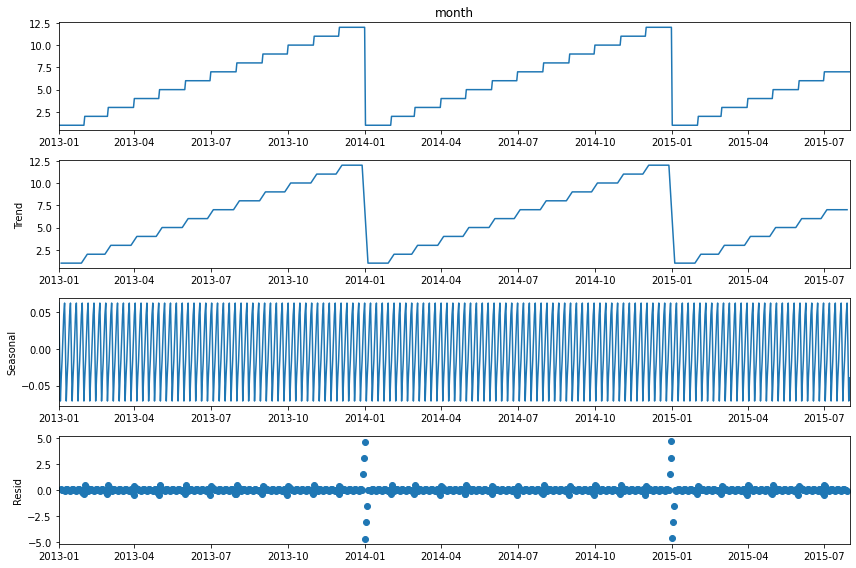

In [96]:
# check decomposition for these variables
for varname in stationarity_checklist:
    print("Variable Name: ",varname)
    check_decomposition(sales_df_1[varname])

In [75]:
# Not used
# split by 80 20 split
def split_data1(df):
    print("shape of main df",df.shape)
    train_data = df[:int(df.shape[0]*0.8)]
    validation_data = df[int(df.shape[0]*0.8):]
    print('shape of train',train_data.shape,'Shape of validation',validation_data.shape)
    return train_data, validation_data

In [131]:
# split dataset by putting the last 6 weeks into test and others into train
def split_data(df):
    print("shape of main df",df.shape)
    train_data = df[:df.last("6W").index[0]]
    train_data.drop(train_data.tail(1).index,inplace=True)
    validation_data = df.last("6W")
    print('shape of train',train_data.shape,'Shape of validation',validation_data.shape)
    return train_data, validation_data

In [559]:
# Split dataset
train_data, validation_data = split_data(sales_df_1)

shape of main df (942, 22)
shape of train (902, 22) Shape of validation (40, 22)


In [133]:
train_data['Sales'].head()

Date
2013-01-01       0.0
2013-01-02    5530.0
2013-01-03    4327.0
2013-01-04    4486.0
2013-01-05    4997.0
Name: Sales, dtype: float64

In [560]:
# Lets use minmax scaler to take care of outliers and also keep values positive
scaler = MinMaxScaler()
train_data[['Sales','Customers']] = scaler.fit_transform(train_data[['Sales','Customers']])
validation_data[['Sales','Customers']] = scaler.transform(validation_data[['Sales','Customers']])

In [135]:
train_data['Sales'].head()

Date
2013-01-01    0.000000
2013-01-02    0.710340
2013-01-03    0.555812
2013-01-04    0.576236
2013-01-05    0.641875
Name: Sales, dtype: float64

### Auto correlation
- plot PACF and ACF graphs to determine the value of p and q to build model. 

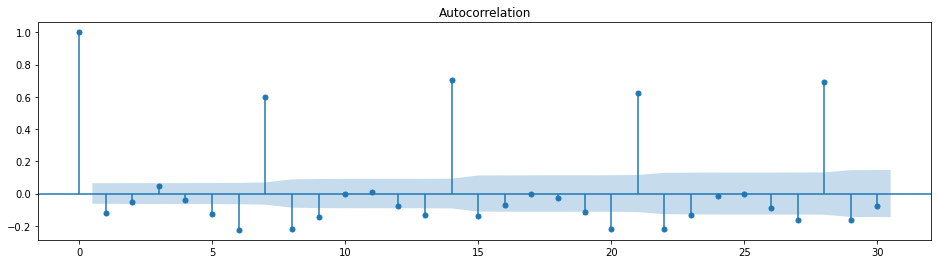

In [136]:
plt.figure(figsize=(16,4))
plot_acf(sales_df_1['Sales'], ax=plt.gca(), lags = 30)
plt.show()

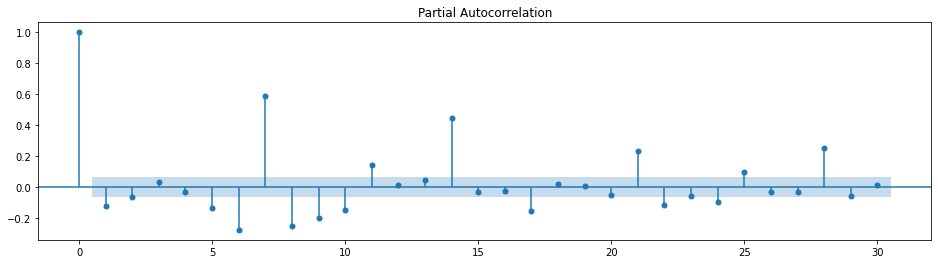

In [137]:
plt.figure(figsize=(16,4))
plot_pacf(sales_df_1['Sales'], ax=plt.gca(), lags = 30)
plt.show()

In [534]:
best_arma = sm.tsa.arma_order_select_ic(sales_df_1['Sales'], max_ar=7, max_ma=7, ic='aic', trend='nc')
print('the best value for ARMA(p,q) is ',best_arma['aic_min_order'])

{'aic':               0             1             2             3             4  \
 0           NaN  18087.295244  17900.221414  17541.118726  17468.113387   
 1  17659.621552  17021.718043  17005.655350  17006.395426  17007.284817   
 2  17415.711025  17007.498851  16997.213775  16958.934443  16955.387845   
 3  17259.313610  17439.409413  16952.035519  16756.743527  16759.855082   
 4  17199.361781  17006.008307  16950.397996  16769.063502  17061.318056   
 5  17190.578473  17057.016825  16942.786765  16685.311490  16744.399834   
 6  17191.931636  17008.209919  16912.266851  16585.786373  16571.984781   
 7  16533.023278  16507.825151  16483.516769  16475.640967  16359.374065   
 
               5             6             7  
 0  17465.366823  17402.129137  17118.147034  
 1  16881.315458  16877.826537  16846.003710  
 2  16878.475398  16879.820599  16761.159225  
 3  16653.594855  16660.076773  16714.737851  
 4  18031.091773  17390.198831  16534.602560  
 5  16374.253256  16270.1

### Observation 
- we see that the best value for p and q is 7 and 7 keeping in mind the computation power

In [138]:
# Get top highly correlated variables to decide on picking endogenous and exogeneous variables
def get_high_correlated(df):
    corr_matrix = df.corr().abs()
    high_correlated_variables_all = corr_matrix['Sales'].sort_values(ascending=False)
    #print(high_correlated_variables_all)
    return high_correlated_variables_all
get_high_correlated(sales_df_1)

Sales                        1.000000
Customers                    0.948927
Open                         0.897752
DayOfWeek                    0.498591
Promo                        0.483189
StateHoliday                 0.304561
CompetitionOpenSince         0.053190
year                         0.053069
SchoolHoliday                0.007133
month                        0.003635
week                         0.001537
Store                             NaN
StoreType                         NaN
Assortment                        NaN
CompetitionDistance               NaN
CompetitionOpenSinceMonth         NaN
CompetitionOpenSinceYear          NaN
Promo2                            NaN
Promo2SinceWeek                   NaN
Promo2SinceYear                   NaN
PromoInterval                     NaN
PromoSince                        NaN
Name: Sales, dtype: float64

### Observation 
- we can choose customers as endogenous variable because when customers are high, the sales are high and when customers are low sales are low. also its vice versa, when sales are high/low its because customers are high/low. hence we can choose Customers as endog
- Other variable which has high correlation like Open, DayOfWeek, Promo etc are external factors impacting sales. hence these can be treated as exog

### Cointegration test
- using johanson test, lets perform cointegration test between our Endogenous Variables Sales and Customer. Other variables 

In [139]:
def check_johansen(df):
    print("Checking for variables: ",df.columns.values)
    res = coint_johansen(df,-1,0)
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')
    rank = select_coint_rank(df,-1,0)
    print("Rank: ",rank.rank)
    if rank.rank == df.columns.shape[0]:
        print("All the variables are cointegrated")

In [173]:
check_johansen(train_data[['Sales','Customers']])

Checking for variables:  ['Sales' 'Customers']
   max_eig_stat  trace_stat
0    265.254304  376.955141
1    111.700836  111.700836 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

Rank:  2
All the variables are cointegrated


### Observation 
- since the rank of matrix is 2, sales and customers variables are cointegrated

### Modelling 

In [611]:
class Model:
    # initialise p and q and endo_vars,exog_vars
    def __init__(self,p,q,endo_vars,exog_vars):
        self.p = p
        self.q = q
        self.endo_vars = endo_vars
        self.exog_vars = exog_vars
        
    def build_varmax_model(self,summary=False):
        self.model = sm.tsa.VARMAX(train_data[self.endo_vars],order=(self.p,self.q),trend='n',exog=train_data[self.exog_vars]) 
        self.model = self.model.fit(maxiter=1000, disp=False)
        self.predictions = self.model.predict(train_data.index.min(), validation_data.index.max(),exog=validation_data[self.exog_vars])
        print("VARMAX model builded successfully")
        if summary:
            print(self.model.summary())
    
    def build_var_model(self,summary=False):
        self.model = sm.tsa.VARMAX(train_data[self.endo_vars],order=(self.p,self.q),trend='n') 
        self.model = self.model.fit(maxiter=1000, disp=False)
        self.predictions = self.model.predict(train_data.index.min(), validation_data.index.max())
        print("VAR model builded successfully")
        if summary:
            print(self.model.summary())
    
    def build_arima_model(self,summary=False):
        self.model = ARIMA(train_data['Sales'], order=(self.p, 0, self.q))
        self.model = self.model.fit(maxiter=1000, disp=False)
        self.predictions = self.model.predict(train_data.index.min(), validation_data.index.max())
        self.predictions = pd.DataFrame(self.predictions,columns=['Sales'])
        print("ARIMA model builded successfully")
        if summary:
            print(self.model.summary())  
            
    def build_arimax_model(self,summary=False):
        self.model = ARIMA(train_data['Sales'], order=(self.p, 0, self.q), exog=train_data[['Customers'] + self.exog_vars])
        self.model = self.model.fit(maxiter=1000, disp=False)
        self.predictions = self.model.predict(train_data.index.min(), validation_data.index.max(),exog=validation_data[['Customers'] + self.exog_vars])
        self.predictions = pd.DataFrame(self.predictions,columns=['Sales'])
        print("ARIMAX model builded successfully")
        if summary:
            print(self.model.summary())  
    def build_sarima_model(self,m=12,summary=False):
        self.model = SARIMAX(train_data['Sales'], order=(self.p, 0, self.q),seasonal_order=(self.p, 0, self.q, m))
        self.model = self.model.fit(maxiter=1000, disp=False)
        self.predictions = self.model.predict(train_data.index.min(), validation_data.index.max())
        self.predictions = pd.DataFrame(self.predictions)
        self.predictions.columns = ['Sales']
        print("SARIMA model builded successfully")
        if summary:
            print(self.model.summary()) 
            
    def build_sarimax_model(self,m=12,summary=False):
        self.model = SARIMAX(train_data['Sales'], order=(self.p, 0, self.q),seasonal_order=(self.p, 0, self.q, m), exog=train_data[['Customers'] + self.exog_vars])
        self.model = self.model.fit(maxiter=1000, disp=False)
        self.predictions = self.model.predict(train_data.index.min(), validation_data.index.max(),exog=validation_data[['Customers'] + self.exog_vars])
        self.predictions = pd.DataFrame(self.predictions)
        self.predictions.columns = ['Sales']
        print("SARIMAX model builded successfully")
        if summary:
            print(self.model.summary())    
    # print total graphs        
    def plot_total_graphs(self,var_name):
        plt.figure(figsize=(16,6))
        plt.plot(train_data[var_name], label='Train')
        plt.plot(validation_data[var_name], label='Test')
        plt.plot(self.predictions[var_name][validation_data.index.min():validation_data.index.max()], label='Model')
        plt.legend(loc='best')
        plt.title('Model - forecasting for '+var_name)
        plt.show()
    # print just prediction graphs
    def plot_prediction_graphs(self,var_name):
        plt.figure(figsize=(16,6))
        plt.plot(validation_data[var_name], label='Test')
        plt.plot(self.predictions[var_name][validation_data.index.min():validation_data.index.max()], label='Model')
        plt.legend(loc='best')
        plt.title('Model - forecasting for '+var_name)
        plt.show()
    # accuracy metrics
    def mean_absolute_percentage_error(self,y_true, y_pred): 
        mask = y_true != 0
        return (np.fabs(y_true - y_pred)/y_true)[mask].mean() * 100
    
    def get_smape(self, y, y_hat):
        return 100/len(y) * np.sum(2 * np.abs(y_hat - y) / (np.abs(y) + np.abs(y_hat)))
    
    def get_r2score(self, y_true, y_pred):
        return r2_score(y_true,y_pred)
    
    def print_accuracy(self):
        rmse = np.sqrt(mean_squared_error(validation_data['Sales'], self.predictions['Sales'][validation_data.index.min():validation_data.index.max()])).round(2)
        print('Sales: RMSE:',  rmse)
        mape_train = np.round(self.mean_absolute_percentage_error(train_data['Sales'], self.predictions['Sales'][train_data.index.min():train_data.index.max()]), 2).round(2)
        print('Sales: Train MAPE:',  mape_train)
        mape = np.round(self.mean_absolute_percentage_error(validation_data['Sales'], self.predictions['Sales'][validation_data.index.min():validation_data.index.max()]), 2).round(2)
        print('Sales: Validation MAPE:',  mape)
        smape = np.round(self.get_smape(validation_data['Sales'], self.predictions['Sales'][validation_data.index.min():validation_data.index.max()]), 2).round(2)
        print('Sales: sMAPE:', smape)
        r2score = np.round(self.get_r2score(validation_data['Sales'], self.predictions['Sales'][validation_data.index.min():validation_data.index.max()]), 2).round(2)
        print('Sales: R2 Score:', r2score)
        return {"rmse": rmse, "r2score": r2score, "smape": smape, "mape":mape,"train_mape":mape_train}

### VARMAX

In [568]:
#,'CompetitionOpenSince','month','week','SchoolHoliday','StateHoliday','year'
store_1_model_varmax = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_1_model_varmax.build_varmax_model(summary=True)
#store_1_model.plot_total_graphs('Sales')
#store_1_model.print_accuracy()

VARMAX model builded successfully
                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  902
Model:                        VARMAX(7,7)   Log Likelihood                3227.645
Date:                    Sun, 20 Jun 2021   AIC                          -6325.289
Time:                            00:28:10   BIC                          -6012.989
Sample:                        01-01-2013   HQIC                         -6206.001
                             - 06-21-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            28.51, 5.03   Jarque-Bera (JB):       770.27, 248.94
Prob(Q):                        0.00, 0.02   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.38, 0.92   Skew:                       0.70, 0.01
Prob(H) (two-sided):            0.01, 0.45   Kurto

In [569]:
accuracy = store_1_model_varmax.print_accuracy()
accuracy
#store_1_model.get_smape(validation_data['Sales'],store_1_model.predictions['Sales'])

Sales: RMSE: 0.05
Sales: Train MAPE: 11.32
Sales: Validation MAPE: 9.79
Sales: sMAPE: 33.08
Sales: R2 Score: 0.93


{'rmse': 0.05,
 'r2score': 0.93,
 'smape': 33.08,
 'mape': 9.79,
 'train_mape': 11.32}

### Observation 
- we see that mape train mape is 11 and validation mape is 9.7. hence there is no overfitting and other metrics such as rsme is also good 

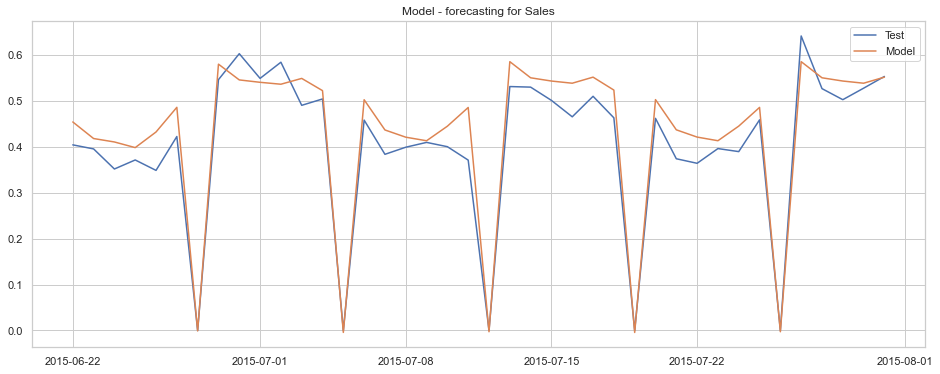

In [563]:
store_1_model_varmax.plot_prediction_graphs('Sales')

### Observation 
we see that graphs for validation and predictions are overlapping

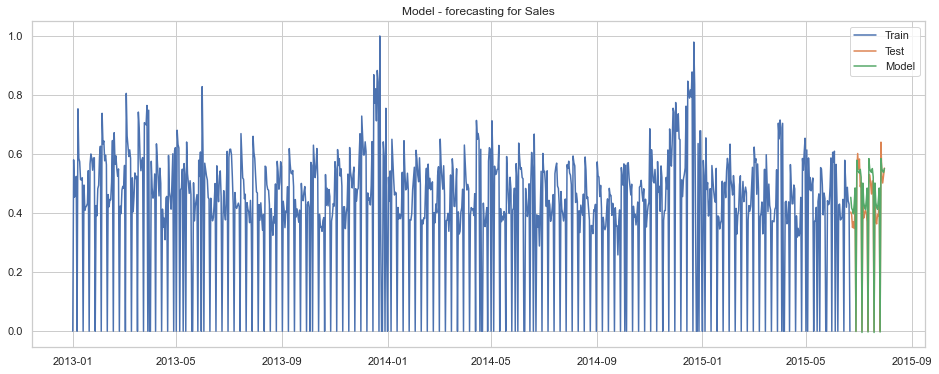

In [564]:
store_1_model_varmax.plot_total_graphs('Sales')

In [570]:
# lets store the accuracy metrics in data frame to compare
model_comparison=pd.DataFrame()
model_comparison.loc[0,'Store Number']=1
model_comparison.loc[0,'Model']='VARMAX'
model_comparison.loc[0,'Variable']='Sales'
model_comparison.loc[0,'RMSE']=accuracy['rmse']
model_comparison.loc[0,'sMAPE']=accuracy['smape']
model_comparison.loc[0,'R2 Score']=accuracy['r2score']
model_comparison.loc[0,'Train MAPE']=accuracy['train_mape']
model_comparison.loc[0,'Validation MAPE']=accuracy['mape']
model_comparison

    

Store Number   Model Variable  RMSE  sMAPE  R2 Score  Train MAPE  \
0           1.0  VARMAX    Sales  0.05  33.08      0.93       11.32   

   Validation MAPE  
0             9.79

In [571]:
# define function to add accuracy to matrix
def add_model_accuracy(model_name,accuracy,store_id):
    return model_comparison.append(pd.DataFrame([[store_id,model_name,'Sales',accuracy['rmse'],accuracy['smape'],accuracy['r2score'],accuracy['train_mape'],accuracy['mape']]],columns=['Store Number','Model','Variable','RMSE','sMAPE','R2 Score','Train MAPE','Validation MAPE']))
    

In [572]:
# lets build one more model with StateHoliday
store_1_model_varmax2 = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo','StateHoliday'])
store_1_model_varmax2.build_varmax_model()
accuracy = store_1_model_varmax2.print_accuracy()


VARMAX model builded successfully
Sales: RMSE: 0.05
Sales: Train MAPE: 11.42
Sales: Validation MAPE: 10.89
Sales: sMAPE: 33.93
Sales: R2 Score: 0.91


### Observation 
- we see mape increased, hence lets not consider this 

In [573]:
model_comparison = add_model_accuracy("VARMAX model-more exog(stateholiday)",accuracy,1)
model_comparison

Store Number                                 Model Variable  RMSE  sMAPE  \
0           1.0                                VARMAX    Sales  0.05  33.08   
0           1.0  VARMAX model-more exog(stateholiday)    Sales  0.05  33.93   

   R2 Score  Train MAPE  Validation MAPE  
0      0.93       11.32             9.79  
0      0.91       11.42            10.89

### Simple VAR 

In [574]:
store_1_model_var = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_1_model_var.build_var_model(summary=False)
accuracy = store_1_model_var.print_accuracy()
model_comparison = add_model_accuracy("Simple VAR model('Sales','Customers')",accuracy,1)
model_comparison

VAR model builded successfully
                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  902
Model:                         VARMA(7,7)   Log Likelihood                2627.673
Date:                    Sun, 20 Jun 2021   AIC                          -5137.345
Time:                            00:37:16   BIC                          -4853.873
Sample:                        01-01-2013   HQIC                         -5029.068
                             - 06-21-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.03, 0.01   Jarque-Bera (JB):       2734.80, 34.18
Prob(Q):                        0.86, 0.90   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.18, 1.04   Skew:                     -1.71, -0.15
Prob(H) (two-sided):            0.16, 0.74   Kurtosis

Store Number                                  Model Variable  RMSE  sMAPE  \
0           1.0                                 VARMAX    Sales  0.05  33.08   
0           1.0   VARMAX model-more exog(stateholiday)    Sales  0.05  33.93   
0           1.0  Simple VAR model('Sales','Customers')    Sales  0.10  41.56   

   R2 Score  Train MAPE  Validation MAPE  
0      0.93       11.32             9.79  
0      0.91       11.42            10.89  
0      0.64       13.51            16.64

### Observation 
- we see that mape increased with VAR as there is no exog variables

### ARIMA

In [575]:
store_1_model_ar = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_1_model_ar.build_arima_model(summary=False)
accuracy = store_1_model_ar.print_accuracy()
model_comparison = add_model_accuracy("ARIMA model",accuracy,1)
model_comparison

ARIMA model builded successfully
                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  902
Model:                     ARMA(7, 7)   Log Likelihood                 612.659
Method:                       css-mle   S.D. of innovations              0.121
Date:                Sun, 20 Jun 2021   AIC                          -1193.319
Time:                        00:38:02   BIC                          -1116.445
Sample:                    01-01-2013   HQIC                         -1163.956
                         - 06-21-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4144      0.007     60.730      0.000       0.401       0.428
ar.L1.Sales    -0.3108        nan        nan        nan         nan         nan
ar.L2.Sales    

Store Number                                  Model Variable  RMSE  sMAPE  \
0           1.0                                 VARMAX    Sales  0.05  33.08   
0           1.0   VARMAX model-more exog(stateholiday)    Sales  0.05  33.93   
0           1.0  Simple VAR model('Sales','Customers')    Sales  0.10  41.56   
0           1.0                            ARIMA model    Sales  0.08  38.90   

   R2 Score  Train MAPE  Validation MAPE  
0      0.93       11.32             9.79  
0      0.91       11.42            10.89  
0      0.64       13.51            16.64  
0      0.77       14.44            16.81

### Observation 
- we see that mape is more than VARMAX, hence still our best model is VARMAX

### ARIMAX

In [588]:
store_1_model_arx = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_1_model_arx.build_arimax_model(summary=False)
accuracy = store_1_model_arx.print_accuracy()
model_comparison = add_model_accuracy("ARIMAX model",accuracy,1)
model_comparison

ARIMAX model builded successfully
Sales: RMSE: 0.02
Sales: Train MAPE: 4.31
Sales: Validation MAPE: 4.26
Sales: sMAPE: 28.79
Sales: R2 Score: 0.98


Store Number                                  Model Variable  RMSE  sMAPE  \
0           1.0                                 VARMAX    Sales  0.05  33.08   
0           1.0   VARMAX model-more exog(stateholiday)    Sales  0.05  33.93   
0           1.0  Simple VAR model('Sales','Customers')    Sales  0.10  41.56   
0           1.0                            ARIMA model    Sales  0.08  38.90   
0           1.0                           ARIMAX model    Sales  0.02  28.79   

   R2 Score  Train MAPE  Validation MAPE  
0      0.93       11.32             9.79  
0      0.91       11.42            10.89  
0      0.64       13.51            16.64  
0      0.77       14.44            16.81  
0      0.98        4.31             4.26

### Observation 
- we see that mape is reduced, ARIMAX is giving good results

### SARIMA

In [613]:
store_1_model_sar = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_1_model_sar.build_sarima_model(summary=False)
accuracy = store_1_model_sar.print_accuracy()
model_comparison = add_model_accuracy("SARIMA model",accuracy,1)
model_comparison

SARIMA model builded successfully
Sales: RMSE: 0.09
Sales: Train MAPE: 16.15
Sales: Validation MAPE: 17.73
Sales: sMAPE: 40.93
Sales: R2 Score: 0.71


Store Number                                  Model Variable  RMSE  sMAPE  \
0           1.0                                 VARMAX    Sales  0.05  33.08   
0           1.0   VARMAX model-more exog(stateholiday)    Sales  0.05  33.93   
0           1.0  Simple VAR model('Sales','Customers')    Sales  0.10  41.56   
0           1.0                            ARIMA model    Sales  0.08  38.90   
0           1.0                           ARIMAX model    Sales  0.02  28.79   
0           1.0                           SARIMA model    Sales  0.09  40.93   

   R2 Score  Train MAPE  Validation MAPE  
0      0.93       11.32             9.79  
0      0.91       11.42            10.89  
0      0.64       13.51            16.64  
0      0.77       14.44            16.81  
0      0.98        4.31             4.26  
0      0.71       16.15            17.73

### Observation 
- we see that mape has increased, hence sarima is not performing well

### SARIMAX

In [614]:
store_1_model_sarx = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_1_model_sarx.build_sarimax_model(summary=False)
accuracy = store_1_model_sarx.print_accuracy()
model_comparison = add_model_accuracy("SARIMAX model",accuracy,1)
model_comparison

SARIMAX model builded successfully
Sales: RMSE: 0.02
Sales: Train MAPE: 4.25
Sales: Validation MAPE: 3.96
Sales: sMAPE: 28.45
Sales: R2 Score: 0.99


Store Number                                  Model Variable  RMSE  sMAPE  \
0           1.0                                 VARMAX    Sales  0.05  33.08   
0           1.0   VARMAX model-more exog(stateholiday)    Sales  0.05  33.93   
0           1.0  Simple VAR model('Sales','Customers')    Sales  0.10  41.56   
0           1.0                            ARIMA model    Sales  0.08  38.90   
0           1.0                           ARIMAX model    Sales  0.02  28.79   
0           1.0                           SARIMA model    Sales  0.09  40.93   
0           1.0                          SARIMAX model    Sales  0.02  28.45   

   R2 Score  Train MAPE  Validation MAPE  
0      0.93       11.32             9.79  
0      0.91       11.42            10.89  
0      0.64       13.51            16.64  
0      0.77       14.44            16.81  
0      0.98        4.31             4.26  
0      0.71       16.15            17.73  
0      0.99        4.25             3.96

### Observation 
- we see that mape is reduced even further than ARIMAX, SARIMAX is giving good results considering the seasonality

### Final Conclusion 
- we see that with variables Sales and Customer as endogeneous and 'Open','DayOfWeek','Promo' as exogeneous, the mape accuracy has turned out be good around 3.96 with SARIMAX Model.

# Store 3

In [615]:
train_data, validation_data = split_data(sales_df_3)

shape of main df (942, 22)
shape of train (902, 22) Shape of validation (40, 22)


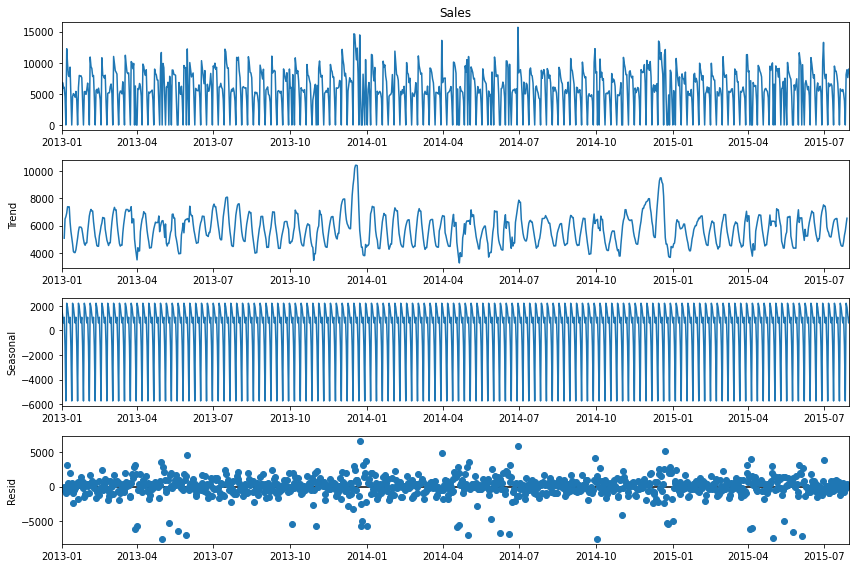

In [192]:
check_decomposition(sales_df_3['Sales'])

In [193]:
check_stationary(sales_df_3['Sales'])

ADF Statistic: -5.911548
Critical Values @ 0.05: -2.86
p-value: 0.000000
Stationary result: True




In [194]:
check_stationary(sales_df_3['Customers'])

ADF Statistic: -5.522483
Critical Values @ 0.05: -2.86
p-value: 0.000002
Stationary result: True




In [195]:
get_high_correlated(sales_df_3)

Sales                        1.000000
Customers                    0.972179
Open                         0.796542
Promo                        0.684001
DayOfWeek                    0.656340
StateHoliday                 0.277956
SchoolHoliday                0.147619
week                         0.053286
month                        0.051391
year                         0.018002
PromoSince                   0.003137
CompetitionOpenSince         0.000749
Store                             NaN
StoreType                         NaN
Assortment                        NaN
CompetitionDistance               NaN
CompetitionOpenSinceMonth         NaN
CompetitionOpenSinceYear          NaN
Promo2                            NaN
Promo2SinceWeek                   NaN
Promo2SinceYear                   NaN
PromoInterval                     NaN
Name: Sales, dtype: float64

In [196]:
check_johansen(sales_df_3[['Sales','Customers']])

Checking for variables:  ['Sales' 'Customers']
   max_eig_stat  trace_stat
0    237.214155  340.425731
1    103.211576  103.211576 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

Rank:  2
All the variables are cointegrated


In [616]:
scaler = MinMaxScaler()
train_data[['Sales','Customers']] = scaler.fit_transform(train_data[['Sales','Customers']])
validation_data[['Sales','Customers']] = scaler.transform(validation_data[['Sales','Customers']])

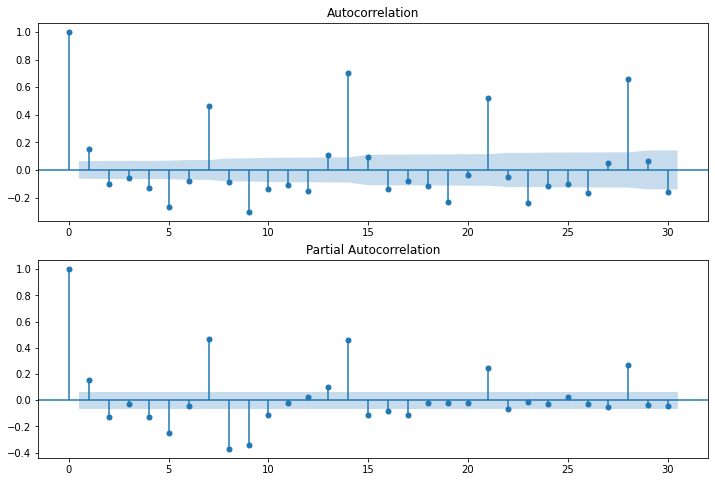

In [202]:

plt.subplot(2,1,1)
plot_acf(sales_df_3['Sales'], ax=plt.gca(), lags = 30)
plt.subplot(2,1,2)
plot_pacf(sales_df_3['Sales'], ax=plt.gca(), lags = 30)
plt.show()

In [617]:
store_3_model = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_3_model.build_varmax_model(summary=True)
accuracy = store_3_model.print_accuracy()
model_comparison = add_model_accuracy("VARMAX('Open','DayOfWeek','Promo') model",accuracy,3)
model_comparison

VARMAX model builded successfully
                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  902
Model:                        VARMAX(7,7)   Log Likelihood                3276.977
Date:                    Sun, 20 Jun 2021   AIC                          -6423.955
Time:                            13:18:35   BIC                          -6111.655
Sample:                        01-01-2013   HQIC                         -6304.666
                             - 06-21-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             9.97, 5.79   Jarque-Bera (JB):      1461.56, 565.61
Prob(Q):                        0.00, 0.02   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.26, 1.06   Skew:                      1.03, -0.25
Prob(H) (two-sided):            0.05, 0.63   Kurto

Store Number                                     Model Variable  RMSE  \
0           1.0                                    VARMAX    Sales  0.05   
0           1.0      VARMAX model-more exog(stateholiday)    Sales  0.05   
0           1.0     Simple VAR model('Sales','Customers')    Sales  0.10   
0           1.0                               ARIMA model    Sales  0.08   
0           1.0                              ARIMAX model    Sales  0.02   
0           1.0                              SARIMA model    Sales  0.09   
0           1.0                             SARIMAX model    Sales  0.02   
0           3.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.06   

   sMAPE  R2 Score  Train MAPE  Validation MAPE  
0  33.08      0.93       11.32             9.79  
0  33.93      0.91       11.42            10.89  
0  41.56      0.64       13.51            16.64  
0  38.90      0.77       14.44            16.81  
0  28.79      0.98        4.31             4.26  
0  40.93      0.71       16.15            17.73  
0  28.45      0.99        4.25             3.96  
0  33.29      0.90       11.35             9.42

In [618]:
store_3_model_var = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_3_model_var.build_var_model(summary=False)
accuracy = store_3_model_var.print_accuracy()
model_comparison = add_model_accuracy("Simple VAR model('Sales','Customers')",accuracy,3)

store_3_model_ar = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_3_model_ar.build_arima_model(summary=False)
accuracy = store_3_model_ar.print_accuracy()
model_comparison = add_model_accuracy("ARIMA model",accuracy,3)

store_3_model_arx = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_3_model_arx.build_arimax_model(summary=False)
accuracy = store_3_model_arx.print_accuracy()
model_comparison = add_model_accuracy("ARIMAX model",accuracy,3)

store_3_model_sar = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_3_model_sar.build_sarima_model(summary=False)
accuracy = store_3_model_sar.print_accuracy()
model_comparison = add_model_accuracy("SARIMA model",accuracy,3)

store_3_model_sarx = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_3_model_sarx.build_sarimax_model(summary=False)
accuracy = store_3_model_sarx.print_accuracy()
model_comparison = add_model_accuracy("SARIMAX model",accuracy,3)

model_comparison[model_comparison['Store Number']==3.0]


VAR model builded successfully
Sales: RMSE: 0.1
Sales: Train MAPE: 16.08
Sales: Validation MAPE: 18.8
Sales: sMAPE: 43.78
Sales: R2 Score: 0.68
ARIMA model builded successfully
Sales: RMSE: 0.1
Sales: Train MAPE: 20.43
Sales: Validation MAPE: 19.01
Sales: sMAPE: 41.05
Sales: R2 Score: 0.71
ARIMAX model builded successfully
Sales: RMSE: 0.05
Sales: Train MAPE: 4.83
Sales: Validation MAPE: 9.02
Sales: sMAPE: 33.38
Sales: R2 Score: 0.94
SARIMA model builded successfully
Sales: RMSE: 0.1
Sales: Train MAPE: 21.69
Sales: Validation MAPE: 18.71
Sales: sMAPE: 41.29
Sales: R2 Score: 0.73
SARIMAX model builded successfully
Sales: RMSE: 0.03
Sales: Train MAPE: 5.09
Sales: Validation MAPE: 5.92
Sales: sMAPE: 30.31
Sales: R2 Score: 0.97


Store Number                                     Model Variable  RMSE  \
0           3.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.06   
0           3.0     Simple VAR model('Sales','Customers')    Sales  0.10   
0           3.0                               ARIMA model    Sales  0.10   
0           3.0                              ARIMAX model    Sales  0.05   
0           3.0                              SARIMA model    Sales  0.10   
0           3.0                             SARIMAX model    Sales  0.03   

   sMAPE  R2 Score  Train MAPE  Validation MAPE  
0  33.29      0.90       11.35             9.42  
0  43.78      0.68       16.08            18.80  
0  41.05      0.71       20.43            19.01  
0  33.38      0.94        4.83             9.02  
0  41.29      0.73       21.69            18.71  
0  30.31      0.97        5.09             5.92

### Final Conclusion 
- we see that with variables Sales and Customer as endogeneous and 'Open','DayOfWeek','Promo' as exogeneous, the mape accuracy has turned out be good around 5.92 with SARIMAX Model again

# Store 8

In [619]:
train_data, validation_data = split_data(sales_df_8)

shape of main df (942, 22)
shape of train (902, 22) Shape of validation (40, 22)


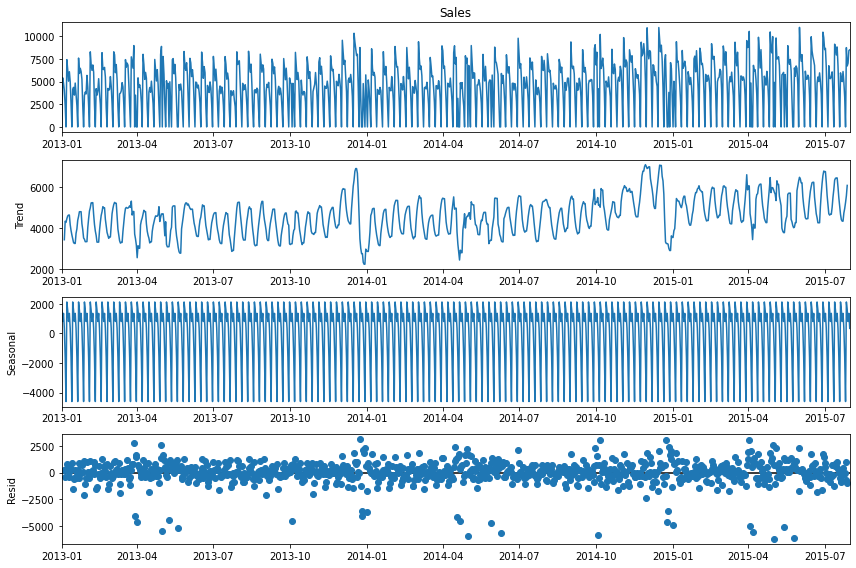

In [205]:
check_decomposition(sales_df_8['Sales'])

In [219]:
check_stationary(sales_df_8['Sales'])
check_stationary(sales_df_8['Customers'])

ADF Statistic: -3.566037
Critical Values @ 0.05: -2.86
p-value: 0.006445
Stationary result: True


ADF Statistic: -3.990325
Critical Values @ 0.05: -2.86
p-value: 0.001462
Stationary result: True




In [208]:
get_high_correlated(sales_df_8)

Sales                        1.000000
Customers                    0.973899
Open                         0.767827
DayOfWeek                    0.712859
Promo                        0.689922
StateHoliday                 0.248760
CompetitionOpenSince         0.142316
year                         0.140950
SchoolHoliday                0.124048
week                         0.054022
month                        0.043771
Store                             NaN
StoreType                         NaN
Assortment                        NaN
CompetitionDistance               NaN
CompetitionOpenSinceMonth         NaN
CompetitionOpenSinceYear          NaN
Promo2                            NaN
Promo2SinceWeek                   NaN
Promo2SinceYear                   NaN
PromoInterval                     NaN
PromoSince                        NaN
Name: Sales, dtype: float64

In [209]:
check_johansen(sales_df_8[['Sales','Customers']])

Checking for variables:  ['Sales' 'Customers']
   max_eig_stat  trace_stat
0    259.423725  356.276671
1     96.852945   96.852945 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

Rank:  2
All the variables are cointegrated


In [621]:
scaler = MinMaxScaler()
train_data[['Sales','Customers']] = scaler.fit_transform(train_data[['Sales','Customers']])
validation_data[['Sales','Customers']] = scaler.transform(validation_data[['Sales','Customers']])

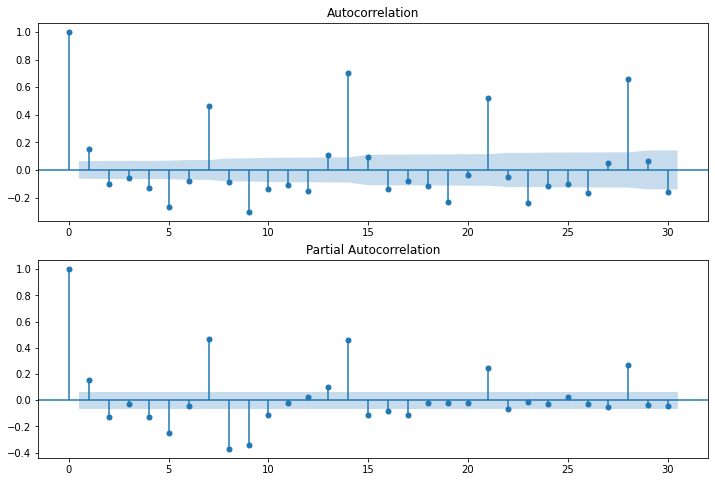

In [222]:

plt.subplot(2,1,1)
plot_acf(sales_df_3['Sales'], ax=plt.gca(), lags = 30)
plt.subplot(2,1,2)
plot_pacf(sales_df_3['Sales'], ax=plt.gca(), lags = 30)
plt.show()

In [622]:
store_8_model = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_8_model.build_varmax_model(summary=True)
accuracy = store_8_model.print_accuracy()
model_comparison = add_model_accuracy("VARMAX('Open','DayOfWeek','Promo') model",accuracy,8)
model_comparison

VARMAX model builded successfully
                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  902
Model:                        VARMAX(7,7)   Log Likelihood                2928.322
Date:                    Sun, 20 Jun 2021   AIC                          -5726.644
Time:                            16:26:31   BIC                          -5414.344
Sample:                        01-01-2013   HQIC                         -5607.355
                             - 06-21-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):           27.12, 10.36   Jarque-Bera (JB):       158.78, 102.49
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.61, 1.49   Skew:                      0.24, -0.16
Prob(H) (two-sided):            0.00, 0.00   Kurto

Store Number                                     Model Variable  RMSE  \
0           1.0                                    VARMAX    Sales  0.05   
0           1.0      VARMAX model-more exog(stateholiday)    Sales  0.05   
0           1.0     Simple VAR model('Sales','Customers')    Sales  0.10   
0           1.0                               ARIMA model    Sales  0.08   
0           1.0                              ARIMAX model    Sales  0.02   
0           1.0                              SARIMA model    Sales  0.09   
0           1.0                             SARIMAX model    Sales  0.02   
0           3.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.06   
0           3.0     Simple VAR model('Sales','Customers')    Sales  0.10   
0           3.0                               ARIMA model    Sales  0.10   
0           3.0                              ARIMAX model    Sales  0.05   
0           3.0                              SARIMA model    Sales  0.10   
0           3.0                             SARIMAX model    Sales  0.03   
0           8.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.11   

   sMAPE  R2 Score  Train MAPE  Validation MAPE  
0  33.08      0.93       11.32             9.79  
0  33.93      0.91       11.42            10.89  
0  41.56      0.64       13.51            16.64  
0  38.90      0.77       14.44            16.81  
0  28.79      0.98        4.31             4.26  
0  40.93      0.71       16.15            17.73  
0  28.45      0.99        4.25             3.96  
0  33.29      0.90       11.35             9.42  
0  43.78      0.68       16.08            18.80  
0  41.05      0.71       20.43            19.01  
0  33.38      0.94        4.83             9.02  
0  41.29      0.73       21.69            18.71  
0  30.31      0.97        5.09             5.92  
0  40.37      0.83       12.17            15.97

In [623]:
store_8_model_var = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_8_model_var.build_var_model(summary=False)
accuracy = store_8_model_var.print_accuracy()
model_comparison = add_model_accuracy("Simple VAR model('Sales','Customers')",accuracy,8)

store_8_model_ar = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_8_model_ar.build_arima_model(summary=False)
accuracy = store_8_model_ar.print_accuracy()
model_comparison = add_model_accuracy("ARIMA model",accuracy,8)

store_8_model_arx = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_8_model_arx.build_arimax_model(summary=False)
accuracy = store_8_model_arx.print_accuracy()
model_comparison = add_model_accuracy("ARIMAX model",accuracy,8)

store_8_model_sar = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_8_model_sar.build_sarima_model(summary=False)
accuracy = store_8_model_sar.print_accuracy()
model_comparison = add_model_accuracy("SARIMA model",accuracy,8)

store_8_model_sarx = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_8_model_sarx.build_sarimax_model(summary=False)
accuracy = store_8_model_sarx.print_accuracy()
model_comparison = add_model_accuracy("SARIMAX model",accuracy,8)

model_comparison[model_comparison['Store Number']==8.0]


VAR model builded successfully
Sales: RMSE: 0.12
Sales: Train MAPE: 13.27
Sales: Validation MAPE: 14.88
Sales: sMAPE: 39.34
Sales: R2 Score: 0.79
ARIMA model builded successfully
Sales: RMSE: 0.16
Sales: Train MAPE: 16.01
Sales: Validation MAPE: 18.27
Sales: sMAPE: 42.84
Sales: R2 Score: 0.63
ARIMAX model builded successfully
Sales: RMSE: 0.05
Sales: Train MAPE: 5.74
Sales: Validation MAPE: 7.2
Sales: sMAPE: 31.55
Sales: R2 Score: 0.96
SARIMA model builded successfully
Sales: RMSE: 0.14
Sales: Train MAPE: 19.53
Sales: Validation MAPE: 20.85
Sales: sMAPE: 43.54
Sales: R2 Score: 0.7
SARIMAX model builded successfully
Sales: RMSE: 0.04
Sales: Train MAPE: 5.6
Sales: Validation MAPE: 5.0
Sales: sMAPE: 29.45
Sales: R2 Score: 0.98


Store Number                                     Model Variable  RMSE  \
0           8.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.11   
0           8.0     Simple VAR model('Sales','Customers')    Sales  0.12   
0           8.0                               ARIMA model    Sales  0.16   
0           8.0                              ARIMAX model    Sales  0.05   
0           8.0                              SARIMA model    Sales  0.14   
0           8.0                             SARIMAX model    Sales  0.04   

   sMAPE  R2 Score  Train MAPE  Validation MAPE  
0  40.37      0.83       12.17            15.97  
0  39.34      0.79       13.27            14.88  
0  42.84      0.63       16.01            18.27  
0  31.55      0.96        5.74             7.20  
0  43.54      0.70       19.53            20.85  
0  29.45      0.98        5.60             5.00

### Final Conclusion 
- we see that with variables Sales and Customer as endogeneous and 'Open','DayOfWeek','Promo' as exogeneous, the mape accuracy has turned out be good around 5 with SARIMAX Model again

# Store 9

In [624]:
train_data, validation_data = split_data(sales_df_9)

shape of main df (942, 22)
shape of train (902, 22) Shape of validation (40, 22)


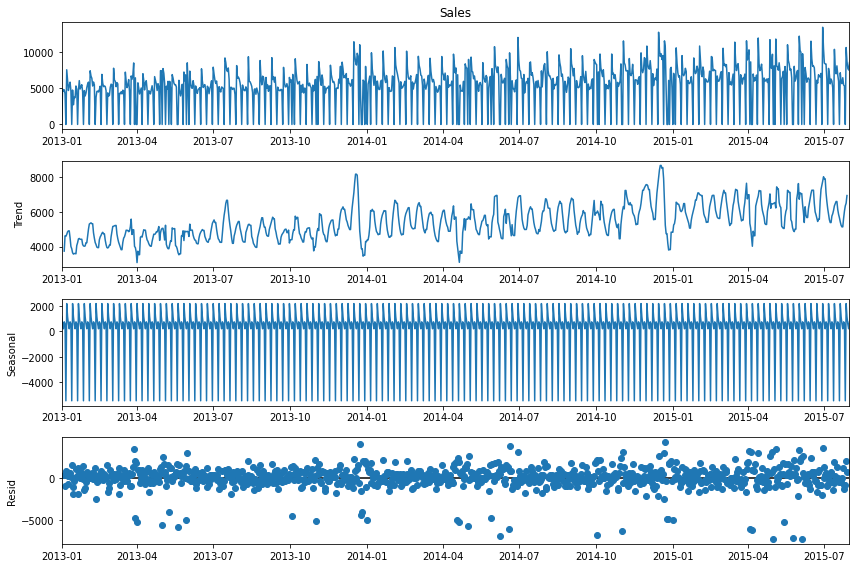

In [229]:
check_decomposition(sales_df_9['Sales'])

In [230]:
check_stationary(sales_df_9['Sales'])
check_stationary(sales_df_9['Customers'])

ADF Statistic: -3.166334
Critical Values @ 0.05: -2.86
p-value: 0.022018
Stationary result: True


ADF Statistic: -3.292751
Critical Values @ 0.05: -2.86
p-value: 0.015206
Stationary result: True




In [231]:
get_high_correlated(sales_df_9)

Sales                        1.000000
Customers                    0.983795
Open                         0.858913
DayOfWeek                    0.583128
Promo                        0.527690
StateHoliday                 0.299721
CompetitionOpenSince         0.219965
year                         0.197585
SchoolHoliday                0.121647
week                         0.048347
month                        0.044989
Store                             NaN
StoreType                         NaN
Assortment                        NaN
CompetitionDistance               NaN
CompetitionOpenSinceMonth         NaN
CompetitionOpenSinceYear          NaN
Promo2                            NaN
Promo2SinceWeek                   NaN
Promo2SinceYear                   NaN
PromoInterval                     NaN
PromoSince                        NaN
Name: Sales, dtype: float64

In [232]:
check_johansen(sales_df_9[['Sales','Customers']])

Checking for variables:  ['Sales' 'Customers']
   max_eig_stat  trace_stat
0    301.064759  412.896081
1    111.831322  111.831322 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

Rank:  2
All the variables are cointegrated


In [625]:
scaler = MinMaxScaler()
train_data[['Sales','Customers']] = scaler.fit_transform(train_data[['Sales','Customers']])
validation_data[['Sales','Customers']] = scaler.transform(validation_data[['Sales','Customers']])

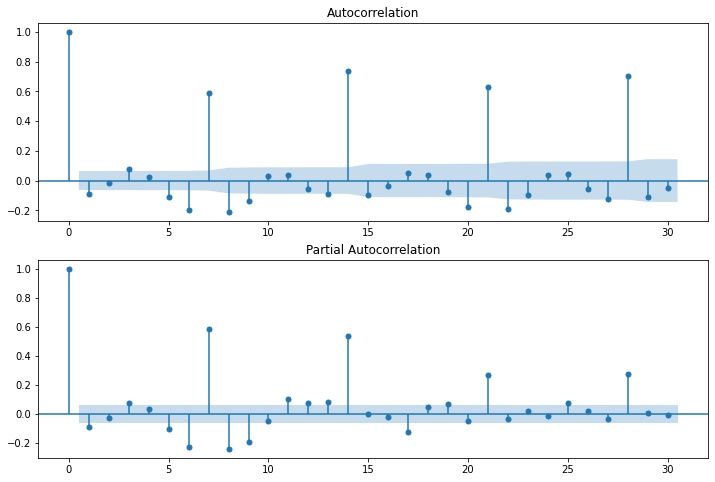

In [234]:

plt.subplot(2,1,1)
plot_acf(sales_df_9['Sales'], ax=plt.gca(), lags = 30)
plt.subplot(2,1,2)
plot_pacf(sales_df_9['Sales'], ax=plt.gca(), lags = 30)
plt.show()

In [626]:
store_9_model = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_9_model.build_varmax_model(summary=True)
accuracy = store_9_model.print_accuracy()
model_comparison = add_model_accuracy("VARMAX('Open','DayOfWeek','Promo') model",accuracy,9)
model_comparison

VARMAX model builded successfully
                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  902
Model:                        VARMAX(7,7)   Log Likelihood                3126.381
Date:                    Sun, 20 Jun 2021   AIC                          -6122.761
Time:                            17:51:25   BIC                          -5810.461
Sample:                        01-01-2013   HQIC                         -6003.473
                             - 06-21-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             2.92, 1.57   Jarque-Bera (JB):      132.86, 1883.76
Prob(Q):                        0.09, 0.21   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.61, 1.30   Skew:                      0.36, -0.19
Prob(H) (two-sided):            0.00, 0.02   Kurto

Store Number                                     Model Variable  RMSE  \
0           1.0                                    VARMAX    Sales  0.05   
0           1.0      VARMAX model-more exog(stateholiday)    Sales  0.05   
0           1.0     Simple VAR model('Sales','Customers')    Sales  0.10   
0           1.0                               ARIMA model    Sales  0.08   
0           1.0                              ARIMAX model    Sales  0.02   
0           1.0                              SARIMA model    Sales  0.09   
0           1.0                             SARIMAX model    Sales  0.02   
0           3.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.06   
0           3.0     Simple VAR model('Sales','Customers')    Sales  0.10   
0           3.0                               ARIMA model    Sales  0.10   
0           3.0                              ARIMAX model    Sales  0.05   
0           3.0                              SARIMA model    Sales  0.10   
0           3.0                             SARIMAX model    Sales  0.03   
0           8.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.11   
0           8.0     Simple VAR model('Sales','Customers')    Sales  0.12   
0           8.0                               ARIMA model    Sales  0.16   
0           8.0                              ARIMAX model    Sales  0.05   
0           8.0                              SARIMA model    Sales  0.14   
0           8.0                             SARIMAX model    Sales  0.04   
0           9.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.11   

   sMAPE  R2 Score  Train MAPE  Validation MAPE  
0  33.08      0.93       11.32             9.79  
0  33.93      0.91       11.42            10.89  
0  41.56      0.64       13.51            16.64  
0  38.90      0.77       14.44            16.81  
0  28.79      0.98        4.31             4.26  
0  40.93      0.71       16.15            17.73  
0  28.45      0.99        4.25             3.96  
0  33.29      0.90       11.35             9.42  
0  43.78      0.68       16.08            18.80  
0  41.05      0.71       20.43            19.01  
0  33.38      0.94        4.83             9.02  
0  41.29      0.73       21.69            18.71  
0  30.31      0.97        5.09             5.92  
0  40.37      0.83       12.17            15.97  
0  39.34      0.79       13.27            14.88  
0  42.84      0.63       16.01            18.27  
0  31.55      0.96        5.74             7.20  
0  43.54      0.70       19.53            20.85  
0  29.45      0.98        5.60             5.00  
0  36.77      0.77       12.31            12.35

In [627]:
store_9_model_var = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_9_model_var.build_var_model(summary=False)
accuracy = store_9_model_var.print_accuracy()
model_comparison = add_model_accuracy("Simple VAR model('Sales','Customers')",accuracy,9)

store_9_model_ar = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_9_model_ar.build_arima_model(summary=False)
accuracy = store_9_model_ar.print_accuracy()
model_comparison = add_model_accuracy("ARIMA model",accuracy,9)

store_9_model_arx = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_9_model_arx.build_arimax_model(summary=False)
accuracy = store_9_model_arx.print_accuracy()
model_comparison = add_model_accuracy("ARIMAX model",accuracy,9)

store_9_model_sar = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_9_model_sar.build_sarima_model(summary=False)
accuracy = store_9_model_sar.print_accuracy()
model_comparison = add_model_accuracy("SARIMA model",accuracy,9)

store_9_model_sarx = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_9_model_sarx.build_sarimax_model(summary=False)
accuracy = store_9_model_sarx.print_accuracy()
model_comparison = add_model_accuracy("SARIMAX model",accuracy,9)

model_comparison[model_comparison['Store Number']==9.0]


VAR model builded successfully
Sales: RMSE: 0.13
Sales: Train MAPE: 13.95
Sales: Validation MAPE: 18.42
Sales: sMAPE: 42.97
Sales: R2 Score: 0.66
ARIMA model builded successfully
Sales: RMSE: 0.12
Sales: Train MAPE: 15.42
Sales: Validation MAPE: 16.62
Sales: sMAPE: 39.31
Sales: R2 Score: 0.75
ARIMAX model builded successfully
Sales: RMSE: 0.04
Sales: Train MAPE: 4.22
Sales: Validation MAPE: 5.21
Sales: sMAPE: 29.69
Sales: R2 Score: 0.97
SARIMA model builded successfully
Sales: RMSE: 0.12
Sales: Train MAPE: 16.7
Sales: Validation MAPE: 16.6
Sales: sMAPE: 39.25
Sales: R2 Score: 0.74
SARIMAX model builded successfully
Sales: RMSE: 0.04
Sales: Train MAPE: 4.29
Sales: Validation MAPE: 4.7
Sales: sMAPE: 29.13
Sales: R2 Score: 0.97


Store Number                                     Model Variable  RMSE  \
0           9.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.11   
0           9.0     Simple VAR model('Sales','Customers')    Sales  0.13   
0           9.0                               ARIMA model    Sales  0.12   
0           9.0                              ARIMAX model    Sales  0.04   
0           9.0                              SARIMA model    Sales  0.12   
0           9.0                             SARIMAX model    Sales  0.04   

   sMAPE  R2 Score  Train MAPE  Validation MAPE  
0  36.77      0.77       12.31            12.35  
0  42.97      0.66       13.95            18.42  
0  39.31      0.75       15.42            16.62  
0  29.69      0.97        4.22             5.21  
0  39.25      0.74       16.70            16.60  
0  29.13      0.97        4.29             4.70

### Final Conclusion 
- we see that with variables Sales and Customer as endogeneous and 'Open','DayOfWeek','Promo' as exogeneous, the mape accuracy has turned out be good around 4.7 with SARIMAX Model again with no overfitting

# Store 13

- This Dataframe has missing series which might lead to failure if not handled

In [724]:
sales_df_13 =sales_df_all[sales_df_all.Store==13]

In [725]:
# Get entire series of dates as this dataframe has missing series itself
dt_range = pd.date_range(sales_df_13.index.min(),sales_df_13.index.max())
dt_range

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25',
               '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29',
               '2015-07-30', '2015-07-31'],
              dtype='datetime64[ns]', length=942, freq='D')

In [726]:
# reindex the dataframe with complete date range above, missing series will have NaN values
sales_df_13 = sales_df_13.reindex(dt_range)
sales_df_13.head()

Store  DayOfWeek   Sales  Customers  Open  Promo  StateHoliday  \
2013-01-01   13.0        2.0     0.0        0.0   0.0    0.0           1.0   
2013-01-02   13.0        3.0  3737.0      317.0   1.0    0.0           0.0   
2013-01-03   13.0        4.0  3674.0      292.0   1.0    0.0           0.0   
2013-01-04   13.0        5.0  3848.0      340.0   1.0    0.0           0.0   
2013-01-05   13.0        6.0  4285.0      344.0   1.0    0.0           0.0   

            SchoolHoliday  StoreType  Assortment  ...  \
2013-01-01            1.0        4.0         1.0  ...   
2013-01-02            1.0        4.0         1.0  ...   
2013-01-03            1.0        4.0         1.0  ...   
2013-01-04            1.0        4.0         1.0  ...   
2013-01-05            0.0        4.0         1.0  ...   

            CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  \
2013-01-01                       0.0     1.0             45.0   
2013-01-02                       0.0     1.0             45.0   
2013-01-03                       0.0     1.0             45.0   
2013-01-04                       0.0     1.0             45.0   
2013-01-05                       0.0     1.0             45.0   

            Promo2SinceYear  PromoInterval    year  month  week  \
2013-01-01           2009.0            2.0  2013.0    1.0   1.0   
2013-01-02           2009.0            2.0  2013.0    1.0   1.0   
2013-01-03           2009.0            2.0  2013.0    1.0   1.0   
2013-01-04           2009.0            2.0  2013.0    1.0   1.0   
2013-01-05           2009.0            2.0  2013.0    1.0   1.0   

            CompetitionOpenSince  PromoSince  
2013-01-01                   0.0        37.0  
2013-01-02                   0.0        37.0  
2013-01-03                   0.0        37.0  
2013-01-04                   0.0        37.0  
2013-01-05                   0.0        37.0  

[5 rows x 22 columns]

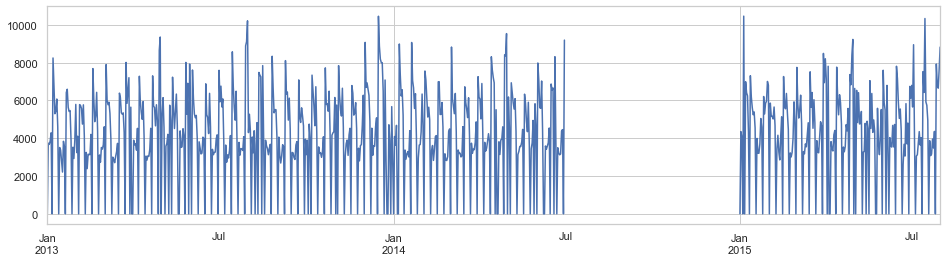

In [727]:
# Check the distribution for Sales
sales_df_13['Sales'].plot(figsize=(16,4))
plt.show()

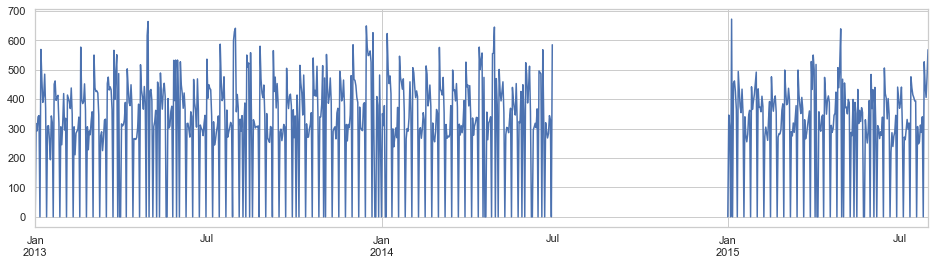

In [728]:
# Check the distribution for Customers
sales_df_13['Customers'].plot(figsize=(16,4))
plt.show()

### Observation 
- we see that the series is missing between July 2014 and Jan 2015
- lets interpolate the missing dates

In [729]:
# lets impute the year, month, and week from index as its straight forward and does not need interpolation
sales_df_13['year'] = sales_df_13.index.year
sales_df_13['month'] = sales_df_13.index.month
sales_df_13['week'] = sales_df_13.index.week

In [730]:
# lets impute the DayOfWeek with index and does not need interpolation
sales_df_13['DayOfWeek'].loc[sales_df_13['DayOfWeek'].isnull()] = sales_df_13[sales_df_13['DayOfWeek'].isnull()].index.day_of_week+1

In [731]:
#sales_df_13.loc[(sales_df_13['DayOfWeek']==7.0) & (sales_df_13['Sales'].isnull()),'Sales'] = 0
#sales_df_13.loc[(sales_df_13['DayOfWeek']==7.0) & (sales_df_13['Customers'].isnull()),'Customers'] = 0

In [732]:
# check sunday and impute the variable Open with 0 as its closed. 
sales_df_13.loc[(sales_df_13['DayOfWeek']==7.0) & (sales_df_13['Open'].isnull()),'Open'] = 0

In [733]:
# check sunday and impute the variable Open with 1 as its open on other days. 
sales_df_13.loc[(sales_df_13['Open'].isnull()),'Open'] = 1

In [734]:
# fill the store id with 13 as we know its for 13
sales_df_13['Store'].fillna(13,inplace=True)

In [735]:
# check null value distribution
sales_df_13.isnull().sum()

Store                          0
DayOfWeek                      0
Sales                        184
Customers                    184
Open                           0
Promo                        184
StateHoliday                 184
SchoolHoliday                184
StoreType                    184
Assortment                   184
CompetitionDistance          184
CompetitionOpenSinceMonth    184
CompetitionOpenSinceYear     184
Promo2                       184
Promo2SinceWeek              184
Promo2SinceYear              184
PromoInterval                184
year                           0
month                          0
week                           0
CompetitionOpenSince         184
PromoSince                   184
dtype: int64

### interpolate missing series

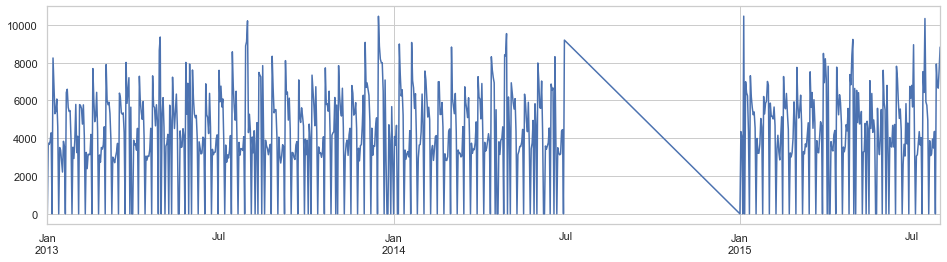

In [736]:
# interpolate with linear line for the misssing series
sales_df_13['Sales'].interpolate(method='time').plot(figsize=(16,4))
plt.show()

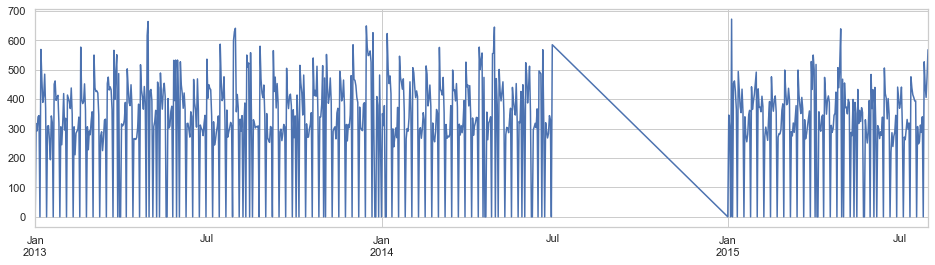

In [737]:
# interpolate with linear line for the misssing series
sales_df_13['Customers'].interpolate(method='time').plot(figsize=(16,4))
plt.show()

In [738]:
sales_df_13 = sales_df_13.interpolate(method='time')
sales_df_13.isnull().sum()

Store                        0
DayOfWeek                    0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
year                         0
month                        0
week                         0
CompetitionOpenSince         0
PromoSince                   0
dtype: int64

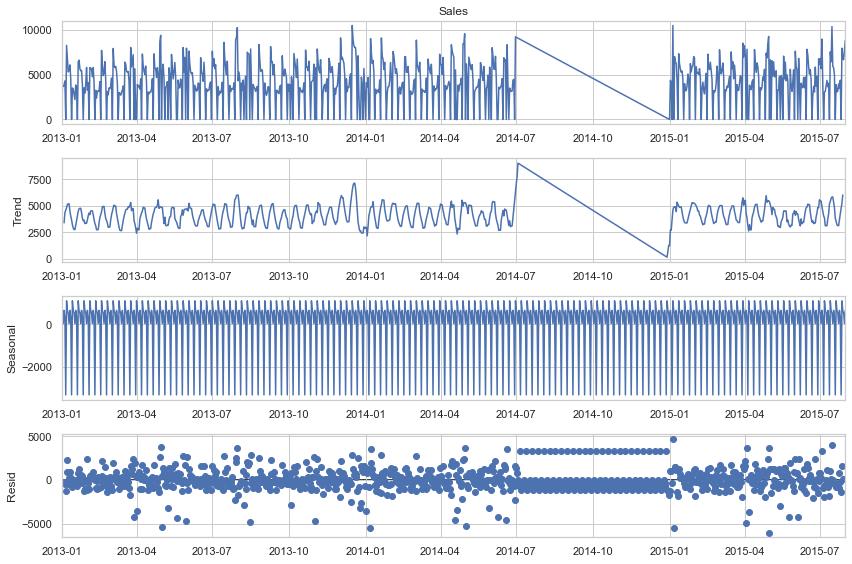

In [739]:
check_decomposition(sales_df_13['Sales'])

In [740]:
check_stationary(sales_df_13['Sales'])
check_stationary(sales_df_13['Customers'])

ADF Statistic: -2.747592
Critical Values @ 0.05: -2.86
p-value: 0.066159
Stationary result: False


ADF Statistic: -2.712135
Critical Values @ 0.05: -2.86
p-value: 0.071962
Stationary result: False




### Observation
- since the sales and customers data is not stationary, we need to convert them to stationary
- we can see there is no trend component and only variance is not constant
- we also see there are high outliers after linear interpolation which is leading to series being slightly non stationary. hence lets treat the outliers

In [741]:
sales_df_13['Sales'] = interpolate_outlier(sales_df_13['Sales'])
sales_df_13['Customers'] = interpolate_outlier(sales_df_13['Customers'])
check_stationary(sales_df_13['Sales'])

ADF Statistic: -2.887714
Critical Values @ 0.05: -2.86
p-value: 0.046796
Stationary result: True




In [742]:
check_stationary(sales_df_13['Customers'])

ADF Statistic: -2.965979
Critical Values @ 0.05: -2.86
p-value: 0.038196
Stationary result: True




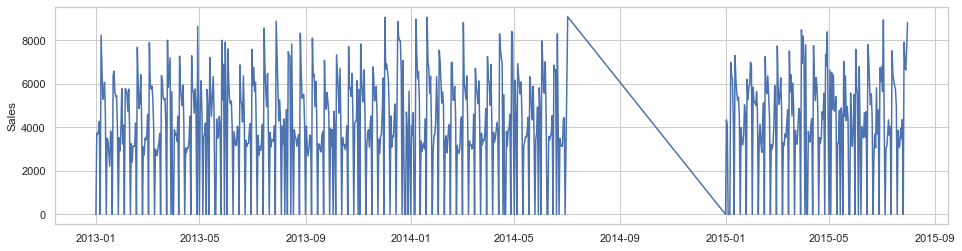

In [743]:
plt.figure(figsize=(16,4))
sns.lineplot(data=sales_df_13['Sales'])
plt.show()

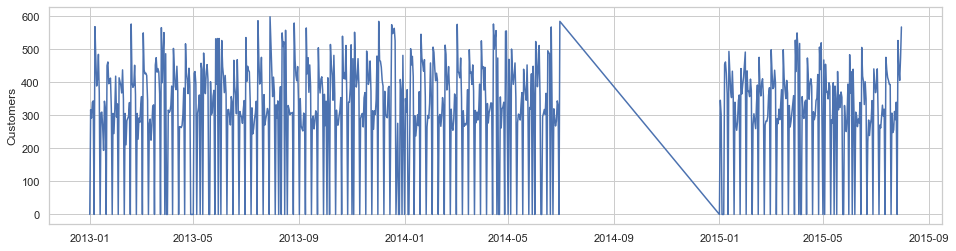

In [744]:
plt.figure(figsize=(16,4))
sns.lineplot(data=sales_df_13['Customers'])
plt.show()

### observation
- we see that series has become stationary now

In [464]:
get_high_correlated(sales_df_13)

Sales                        1.000000
Customers                    0.996503
Open                         0.895262
DayOfWeek                    0.457510
Promo                        0.371657
StateHoliday                 0.248390
week                         0.070030
SchoolHoliday                0.067619
month                        0.050256
PromoSince                   0.043648
year                         0.020022
Store                             NaN
StoreType                         NaN
Assortment                        NaN
CompetitionDistance               NaN
CompetitionOpenSinceMonth         NaN
CompetitionOpenSinceYear          NaN
Promo2                            NaN
Promo2SinceWeek                   NaN
Promo2SinceYear                   NaN
PromoInterval                     NaN
CompetitionOpenSince              NaN
Name: Sales, dtype: float64

In [745]:
check_johansen(sales_df_13[['Sales','Customers']])

Checking for variables:  ['Sales' 'Customers']
   max_eig_stat  trace_stat
0    301.297211  397.604503
1     96.307292   96.307292 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

Rank:  2
All the variables are cointegrated


In [746]:
# split dataset
train_data, validation_data = split_data(sales_df_13)

shape of main df (942, 22)
shape of train (902, 22) Shape of validation (40, 22)


In [747]:
scaler = MinMaxScaler()
train_data[['Sales','Customers']] = scaler.fit_transform(train_data[['Sales','Customers']])
validation_data[['Sales','Customers']] = scaler.transform(validation_data[['Sales','Customers']])

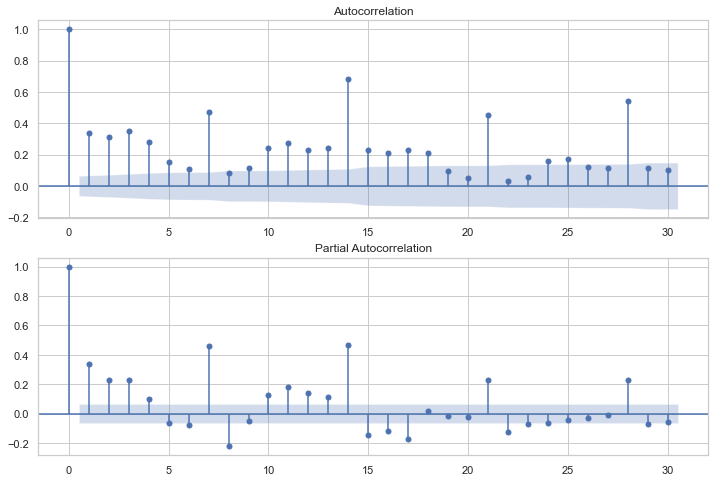

In [748]:

plt.subplot(2,1,1)
plot_acf(sales_df_13['Sales'], ax=plt.gca(), lags = 30)
plt.subplot(2,1,2)
plot_pacf(sales_df_13['Sales'], ax=plt.gca(), lags = 30)
plt.show()

In [749]:
store_13_model = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_13_model.build_varmax_model(summary=True)
accuracy = store_13_model.print_accuracy()
model_comparison = add_model_accuracy("VARMAX('Open','DayOfWeek','Promo') model",accuracy,13)
model_comparison

VARMAX model builded successfully
                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  902
Model:                        VARMAX(7,7)   Log Likelihood                1842.800
Date:                    Mon, 21 Jun 2021   AIC                          -3555.600
Time:                            16:28:41   BIC                          -3243.300
Sample:                        01-01-2013   HQIC                         -3436.311
                             - 06-21-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             6.02, 0.09   Jarque-Bera (JB):    507.02, 257954.92
Prob(Q):                        0.01, 0.76   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.66, 0.38   Skew:                     -0.35, -4.71
Prob(H) (two-sided):            0.00, 0.00   Kurto

Store Number                                     Model Variable  RMSE  \
0           1.0                                    VARMAX    Sales  0.05   
0           1.0      VARMAX model-more exog(stateholiday)    Sales  0.05   
0           1.0     Simple VAR model('Sales','Customers')    Sales  0.10   
0           1.0                               ARIMA model    Sales  0.08   
0           1.0                              ARIMAX model    Sales  0.02   
0           1.0                              SARIMA model    Sales  0.09   
0           1.0                             SARIMAX model    Sales  0.02   
0           3.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.06   
0           3.0     Simple VAR model('Sales','Customers')    Sales  0.10   
0           3.0                               ARIMA model    Sales  0.10   
0           3.0                              ARIMAX model    Sales  0.05   
0           3.0                              SARIMA model    Sales  0.10   
0           3.0                             SARIMAX model    Sales  0.03   
0           8.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.11   
0           8.0     Simple VAR model('Sales','Customers')    Sales  0.12   
0           8.0                               ARIMA model    Sales  0.16   
0           8.0                              ARIMAX model    Sales  0.05   
0           8.0                              SARIMA model    Sales  0.14   
0           8.0                             SARIMAX model    Sales  0.04   
0           9.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.11   
0           9.0     Simple VAR model('Sales','Customers')    Sales  0.13   
0           9.0                               ARIMA model    Sales  0.12   
0           9.0                              ARIMAX model    Sales  0.04   
0           9.0                              SARIMA model    Sales  0.12   
0           9.0                             SARIMAX model    Sales  0.04   
0          25.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.05   
0          25.0     Simple VAR model('Sales','Customers')    Sales  0.08   
0          25.0                               ARIMA model    Sales  0.07   
0          25.0                              ARIMAX model    Sales  0.04   
0          25.0                              SARIMA model    Sales  0.07   
0          25.0                             SARIMAX model    Sales  0.04   
0          29.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.08   
0          29.0     Simple VAR model('Sales','Customers')    Sales  0.13   
0          29.0                               ARIMA model    Sales  0.12   
0          29.0                              ARIMAX model    Sales  0.03   
0          29.0                              SARIMA model    Sales  0.11   
0          29.0                             SARIMAX model    Sales  0.03   
0          31.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.06   
0          31.0     Simple VAR model('Sales','Customers')    Sales  0.10   
0          31.0                               ARIMA model    Sales  0.08   
0          13.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.10   
0          13.0     Simple VAR model('Sales','Customers')    Sales  0.21   
0          13.0                               ARIMA model    Sales  0.09   
0          13.0                              ARIMAX model    Sales  0.02   
0          13.0                              SARIMA model    Sales  0.10   
0          13.0                             SARIMAX model    Sales  0.02   
0          31.0                              SARIMA model    Sales  0.10   
0          31.0                             SARIMAX model    Sales  0.02   
0          31.0     Simple VAR model('Sales','Customers')    Sales  0.21   
0          31.0                               ARIMA model    Sales  0.09   
0          46.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.10   
0          46.0     Simple VAR model('Sales','Custo

In [752]:
store_13_model_var = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_13_model_var.build_var_model(summary=False)
accuracy = store_13_model_var.print_accuracy()
model_comparison = add_model_accuracy("Simple VAR model('Sales','Customers')",accuracy,13)

store_13_model_sar = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_13_model_sar.build_sarima_model(summary=False)
accuracy = store_13_model_sar.print_accuracy()
model_comparison = add_model_accuracy("SARIMA model",accuracy,13)

store_13_model_sarx = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_13_model_sarx.build_sarimax_model(summary=False)
accuracy = store_13_model_sarx.print_accuracy()
model_comparison = add_model_accuracy("SARIMAX model",accuracy,13)

model_comparison[model_comparison['Store Number']==13.0]


VAR model builded successfully
Sales: RMSE: 0.22
Sales: Train MAPE: 20.15
Sales: Validation MAPE: 34.59
Sales: sMAPE: 57.26
Sales: R2 Score: 0.29
SARIMA model builded successfully
Sales: RMSE: 0.16
Sales: Train MAPE: 27.03
Sales: Validation MAPE: 22.32
Sales: sMAPE: 45.81
Sales: R2 Score: 0.63
SARIMAX model builded successfully
Sales: RMSE: 0.07
Sales: Train MAPE: 6.61
Sales: Validation MAPE: 6.66
Sales: sMAPE: 31.17
Sales: R2 Score: 0.93


Store Number                                     Model Variable  RMSE  \
0          13.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.10   
0          13.0     Simple VAR model('Sales','Customers')    Sales  0.21   
0          13.0                               ARIMA model    Sales  0.09   
0          13.0                              ARIMAX model    Sales  0.02   
0          13.0                              SARIMA model    Sales  0.10   
0          13.0                             SARIMAX model    Sales  0.02   
0          13.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.11   
0          13.0     Simple VAR model('Sales','Customers')    Sales  0.22   
0          13.0                               ARIMA model    Sales  0.20   
0          13.0     Simple VAR model('Sales','Customers')    Sales  0.22   
0          13.0     Simple VAR model('Sales','Customers')    Sales  0.22   
0          13.0                              SARIMA model    Sales  0.16   
0          13.0                             SARIMAX model    Sales  0.07   

   sMAPE  R2 Score  Train MAPE  Validation MAPE  
0  31.92      0.90        8.74             8.20  
0  37.79      0.55        8.75            13.39  
0  31.66      0.92        7.37             7.21  
0  25.94      1.00        0.73             1.06  
0  32.72      0.89        8.11             8.23  
0  26.24      1.00        0.73             1.39  
0  37.23      0.83       29.08            13.13  
0  57.26      0.29       20.15            34.59  
0  53.87      0.41       32.00            33.84  
0  57.26      0.29       20.15            34.59  
0  57.26      0.29       20.15            34.59  
0  45.81      0.63       27.03            22.32  
0  31.17      0.93        6.61             6.66

### Final Conclusion 
- we see that with variables Sales and Customer as endogeneous and 'Open','DayOfWeek','Promo' as exogeneous, the mape accuracy has turned out be good around 6.66 with SARIMAX Model again with no overfitting

# Store 25

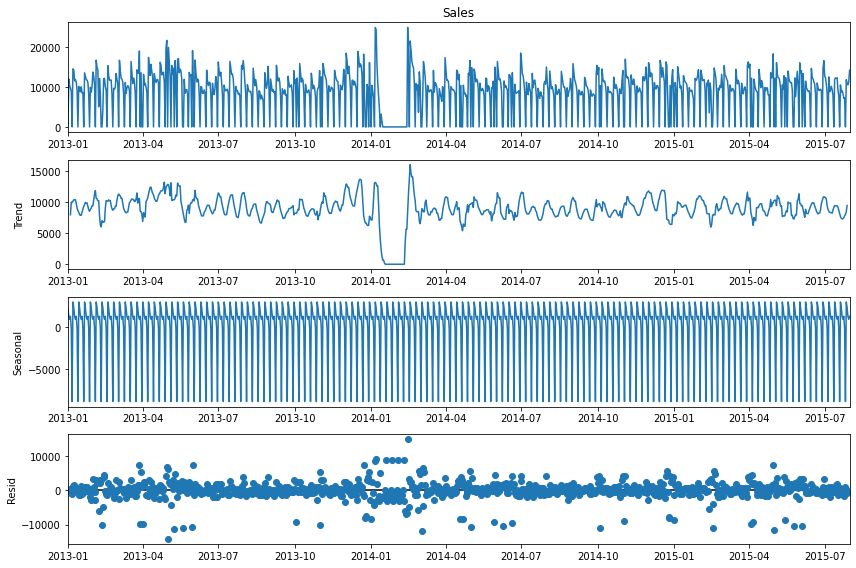

In [469]:
check_decomposition(sales_df_25['Sales'])

In [470]:
check_stationary(sales_df_25['Sales'])
check_stationary(sales_df_25['Customers'])

ADF Statistic: -4.767952
Critical Values @ 0.05: -2.86
p-value: 0.000063
Stationary result: True


ADF Statistic: -4.040782
Critical Values @ 0.05: -2.86
p-value: 0.001211
Stationary result: True




In [471]:
get_high_correlated(sales_df_25)

Sales                        1.000000
Customers                    0.984000
Open                         0.868090
DayOfWeek                    0.561949
Promo                        0.506609
StateHoliday                 0.275670
SchoolHoliday                0.134266
month                        0.076986
week                         0.076013
year                         0.053680
CompetitionOpenSince         0.026337
Store                             NaN
StoreType                         NaN
Assortment                        NaN
CompetitionDistance               NaN
CompetitionOpenSinceMonth         NaN
CompetitionOpenSinceYear          NaN
Promo2                            NaN
Promo2SinceWeek                   NaN
Promo2SinceYear                   NaN
PromoInterval                     NaN
PromoSince                        NaN
Name: Sales, dtype: float64

In [472]:
check_johansen(sales_df_25[['Sales','Customers']])

Checking for variables:  ['Sales' 'Customers']
   max_eig_stat  trace_stat
0    256.305420  362.367936
1    106.062516  106.062516 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

Rank:  2
All the variables are cointegrated


In [ ]:
train_data, validation_data = split_data(sales_df_25)

In [ ]:
scaler = MinMaxScaler()
train_data[['Sales','Customers']] = scaler.fit_transform(train_data[['Sales','Customers']])
validation_data[['Sales','Customers']] = scaler.transform(validation_data[['Sales','Customers']])

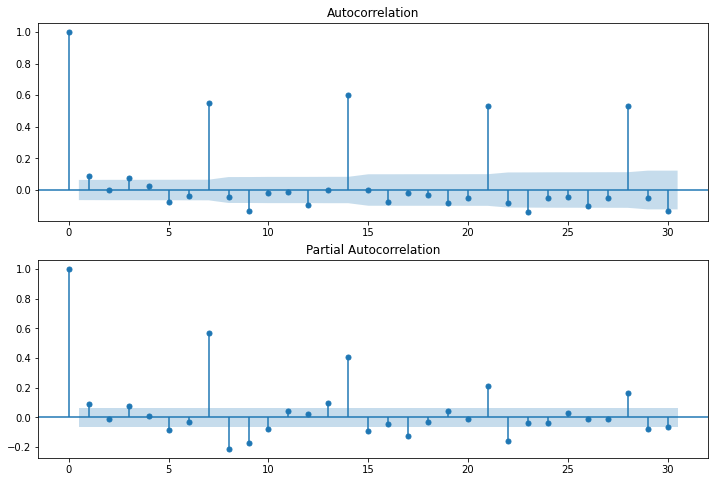

In [476]:

plt.subplot(2,1,1)
plot_acf(sales_df_25['Sales'], ax=plt.gca(), lags = 30)
plt.subplot(2,1,2)
plot_pacf(sales_df_25['Sales'], ax=plt.gca(), lags = 30)
plt.show()

In [631]:
store_25_model = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_25_model.build_varmax_model(summary=True)
accuracy = store_25_model.print_accuracy()
model_comparison = add_model_accuracy("VARMAX('Open','DayOfWeek','Promo') model",accuracy,25)
model_comparison

VARMAX model builded successfully
                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  902
Model:                        VARMAX(7,7)   Log Likelihood                3111.721
Date:                    Sun, 20 Jun 2021   AIC                          -6093.441
Time:                            21:31:17   BIC                          -5781.141
Sample:                        01-01-2013   HQIC                         -5974.153
                             - 06-21-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             4.43, 0.46   Jarque-Bera (JB):    4098.94, 30468.67
Prob(Q):                        0.04, 0.50   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.67, 0.77   Skew:                      0.62, -2.95
Prob(H) (two-sided):            0.00, 0.02   Kurto

Store Number                                     Model Variable  RMSE  \
0           1.0                                    VARMAX    Sales  0.05   
0           1.0      VARMAX model-more exog(stateholiday)    Sales  0.05   
0           1.0     Simple VAR model('Sales','Customers')    Sales  0.10   
0           1.0                               ARIMA model    Sales  0.08   
0           1.0                              ARIMAX model    Sales  0.02   
0           1.0                              SARIMA model    Sales  0.09   
0           1.0                             SARIMAX model    Sales  0.02   
0           3.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.06   
0           3.0     Simple VAR model('Sales','Customers')    Sales  0.10   
0           3.0                               ARIMA model    Sales  0.10   
0           3.0                              ARIMAX model    Sales  0.05   
0           3.0                              SARIMA model    Sales  0.10   
0           3.0                             SARIMAX model    Sales  0.03   
0           8.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.11   
0           8.0     Simple VAR model('Sales','Customers')    Sales  0.12   
0           8.0                               ARIMA model    Sales  0.16   
0           8.0                              ARIMAX model    Sales  0.05   
0           8.0                              SARIMA model    Sales  0.14   
0           8.0                             SARIMAX model    Sales  0.04   
0           9.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.11   
0           9.0     Simple VAR model('Sales','Customers')    Sales  0.13   
0           9.0                               ARIMA model    Sales  0.12   
0           9.0                              ARIMAX model    Sales  0.04   
0           9.0                              SARIMA model    Sales  0.12   
0           9.0                             SARIMAX model    Sales  0.04   
0          25.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.05   

   sMAPE  R2 Score  Train MAPE  Validation MAPE  
0  33.08      0.93       11.32             9.79  
0  33.93      0.91       11.42            10.89  
0  41.56      0.64       13.51            16.64  
0  38.90      0.77       14.44            16.81  
0  28.79      0.98        4.31             4.26  
0  40.93      0.71       16.15            17.73  
0  28.45      0.99        4.25             3.96  
0  33.29      0.90       11.35             9.42  
0  43.78      0.68       16.08            18.80  
0  41.05      0.71       20.43            19.01  
0  33.38      0.94        4.83             9.02  
0  41.29      0.73       21.69            18.71  
0  30.31      0.97        5.09             5.92  
0  40.37      0.83       12.17            15.97  
0  39.34      0.79       13.27            14.88  
0  42.84      0.63       16.01            18.27  
0  31.55      0.96        5.74             7.20  
0  43.54      0.70       19.53            20.85  
0  29.45      0.98        5.60             5.00  
0  36.77      0.77       12.31            12.35  
0  42.97      0.66       13.95            18.42  
0  39.31      0.75       15.42            16.62  
0  29.69      0.97        4.22             5.21  
0  39.25      0.74       16.70            16.60  
0  29.13      0.97        4.29             4.70  
0  33.92      0.89       12.36            10.83

In [632]:
store_25_model_var = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_25_model_var.build_var_model(summary=False)
accuracy = store_25_model_var.print_accuracy()
model_comparison = add_model_accuracy("Simple VAR model('Sales','Customers')",accuracy,25)

store_25_model_ar = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_25_model_ar.build_arima_model(summary=False)
accuracy = store_25_model_ar.print_accuracy()
model_comparison = add_model_accuracy("ARIMA model",accuracy,25)

store_25_model_arx = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_25_model_arx.build_arimax_model(summary=False)
accuracy = store_25_model_arx.print_accuracy()
model_comparison = add_model_accuracy("ARIMAX model",accuracy,25)

store_25_model_sar = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_25_model_sar.build_sarima_model(summary=False)
accuracy = store_25_model_sar.print_accuracy()
model_comparison = add_model_accuracy("SARIMA model",accuracy,25)

store_25_model_sarx = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_25_model_sarx.build_sarimax_model(summary=False)
accuracy = store_25_model_sarx.print_accuracy()
model_comparison = add_model_accuracy("SARIMAX model",accuracy,25)

model_comparison[model_comparison['Store Number']==25.0]


VAR model builded successfully
Sales: RMSE: 0.08
Sales: Train MAPE: 16.08
Sales: Validation MAPE: 15.59
Sales: sMAPE: 39.03
Sales: R2 Score: 0.72
ARIMA model builded successfully
Sales: RMSE: 0.07
Sales: Train MAPE: 16.65
Sales: Validation MAPE: 13.94
Sales: sMAPE: 37.17
Sales: R2 Score: 0.8
ARIMAX model builded successfully
Sales: RMSE: 0.04
Sales: Train MAPE: 4.06
Sales: Validation MAPE: 7.74
Sales: sMAPE: 32.15
Sales: R2 Score: 0.94
SARIMA model builded successfully
Sales: RMSE: 0.07
Sales: Train MAPE: 18.36
Sales: Validation MAPE: 14.22
Sales: sMAPE: 37.16
Sales: R2 Score: 0.81
SARIMAX model builded successfully
Sales: RMSE: 0.04
Sales: Train MAPE: 4.19
Sales: Validation MAPE: 8.11
Sales: sMAPE: 32.52
Sales: R2 Score: 0.94


Store Number                                     Model Variable  RMSE  \
0          25.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.05   
0          25.0     Simple VAR model('Sales','Customers')    Sales  0.08   
0          25.0                               ARIMA model    Sales  0.07   
0          25.0                              ARIMAX model    Sales  0.04   
0          25.0                              SARIMA model    Sales  0.07   
0          25.0                             SARIMAX model    Sales  0.04   

   sMAPE  R2 Score  Train MAPE  Validation MAPE  
0  33.92      0.89       12.36            10.83  
0  39.03      0.72       16.08            15.59  
0  37.17      0.80       16.65            13.94  
0  32.15      0.94        4.06             7.74  
0  37.16      0.81       18.36            14.22  
0  32.52      0.94        4.19             8.11

### Final Conclusion 
- we see that with variables Sales and Customer as endogeneous and 'Open','DayOfWeek','Promo' as exogeneous, the mape accuracy has turned out be good around 8.11 with ARIMAX Model again with no overfitting

# Store 29

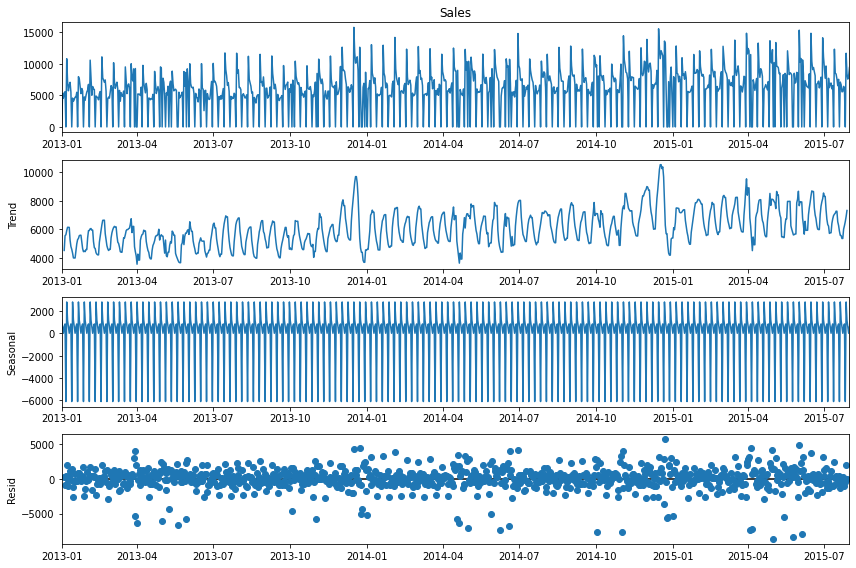

In [478]:
check_decomposition(sales_df_29['Sales'])

In [479]:
check_stationary(sales_df_29['Sales'])
check_stationary(sales_df_29['Customers'])

ADF Statistic: -3.424492
Critical Values @ 0.05: -2.86
p-value: 0.010152
Stationary result: True


ADF Statistic: -3.266280
Critical Values @ 0.05: -2.86
p-value: 0.016455
Stationary result: True




In [480]:
get_high_correlated(sales_df_29)

Sales                        1.000000
Customers                    0.981767
Open                         0.811861
Promo                        0.569974
DayOfWeek                    0.567669
StateHoliday                 0.283302
year                         0.179107
SchoolHoliday                0.096089
week                         0.046137
month                        0.040294
Store                             NaN
StoreType                         NaN
Assortment                        NaN
CompetitionDistance               NaN
CompetitionOpenSinceMonth         NaN
CompetitionOpenSinceYear          NaN
Promo2                            NaN
Promo2SinceWeek                   NaN
Promo2SinceYear                   NaN
PromoInterval                     NaN
CompetitionOpenSince              NaN
PromoSince                        NaN
Name: Sales, dtype: float64

In [481]:
check_johansen(sales_df_29[['Sales','Customers']])

Checking for variables:  ['Sales' 'Customers']
   max_eig_stat  trace_stat
0    302.351282  425.061154
1    122.709871  122.709871 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

Rank:  2
All the variables are cointegrated


In [633]:
train_data, validation_data = split_data(sales_df_29)

shape of main df (942, 22)
shape of train (902, 22) Shape of validation (40, 22)


In [634]:
scaler = MinMaxScaler()
train_data[['Sales','Customers']] = scaler.fit_transform(train_data[['Sales','Customers']])
validation_data[['Sales','Customers']] = scaler.transform(validation_data[['Sales','Customers']])

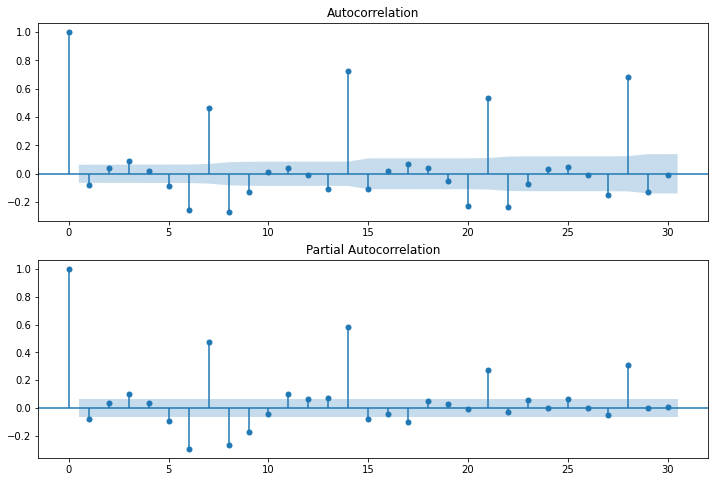

In [484]:

plt.subplot(2,1,1)
plot_acf(sales_df_29['Sales'], ax=plt.gca(), lags = 30)
plt.subplot(2,1,2)
plot_pacf(sales_df_29['Sales'], ax=plt.gca(), lags = 30)
plt.show()

In [635]:
store_29_model = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_29_model.build_varmax_model(summary=True)
accuracy = store_29_model.print_accuracy()
model_comparison = add_model_accuracy("VARMAX('Open','DayOfWeek','Promo') model",accuracy,29)
model_comparison

VARMAX model builded successfully
                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  902
Model:                        VARMAX(7,7)   Log Likelihood                3116.069
Date:                    Sun, 20 Jun 2021   AIC                          -6102.137
Time:                            22:37:04   BIC                          -5789.837
Sample:                        01-01-2013   HQIC                         -5982.849
                             - 06-21-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             4.66, 3.51   Jarque-Bera (JB):      252.30, 1240.25
Prob(Q):                        0.03, 0.06   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.38, 1.15   Skew:                      0.61, -0.28
Prob(H) (two-sided):            0.01, 0.23   Kurto

Store Number                                     Model Variable  RMSE  \
0           1.0                                    VARMAX    Sales  0.05   
0           1.0      VARMAX model-more exog(stateholiday)    Sales  0.05   
0           1.0     Simple VAR model('Sales','Customers')    Sales  0.10   
0           1.0                               ARIMA model    Sales  0.08   
0           1.0                              ARIMAX model    Sales  0.02   
0           1.0                              SARIMA model    Sales  0.09   
0           1.0                             SARIMAX model    Sales  0.02   
0           3.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.06   
0           3.0     Simple VAR model('Sales','Customers')    Sales  0.10   
0           3.0                               ARIMA model    Sales  0.10   
0           3.0                              ARIMAX model    Sales  0.05   
0           3.0                              SARIMA model    Sales  0.10   
0           3.0                             SARIMAX model    Sales  0.03   
0           8.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.11   
0           8.0     Simple VAR model('Sales','Customers')    Sales  0.12   
0           8.0                               ARIMA model    Sales  0.16   
0           8.0                              ARIMAX model    Sales  0.05   
0           8.0                              SARIMA model    Sales  0.14   
0           8.0                             SARIMAX model    Sales  0.04   
0           9.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.11   
0           9.0     Simple VAR model('Sales','Customers')    Sales  0.13   
0           9.0                               ARIMA model    Sales  0.12   
0           9.0                              ARIMAX model    Sales  0.04   
0           9.0                              SARIMA model    Sales  0.12   
0           9.0                             SARIMAX model    Sales  0.04   
0          25.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.05   
0          25.0     Simple VAR model('Sales','Customers')    Sales  0.08   
0          25.0                               ARIMA model    Sales  0.07   
0          25.0                              ARIMAX model    Sales  0.04   
0          25.0                              SARIMA model    Sales  0.07   
0          25.0                             SARIMAX model    Sales  0.04   
0          29.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.08   

   sMAPE  R2 Score  Train MAPE  Validation MAPE  
0  33.08      0.93       11.32             9.79  
0  33.93      0.91       11.42            10.89  
0  41.56      0.64       13.51            16.64  
0  38.90      0.77       14.44            16.81  
0  28.79      0.98        4.31             4.26  
0  40.93      0.71       16.15            17.73  
0  28.45      0.99        4.25             3.96  
0  33.29      0.90       11.35             9.42  
0  43.78      0.68       16.08            18.80  
0  41.05      0.71       20.43            19.01  
0  33.38      0.94        4.83             9.02  
0  41.29      0.73       21.69            18.71  
0  30.31      0.97        5.09             5.92  
0  40.37      0.83       12.17            15.97  
0  39.34      0.79       13.27            14.88  
0  42.84      0.63       16.01            18.27  
0  31.55      0.96        5.74             7.20  
0  43.54      0.70       19.53            20.85  
0  29.45      0.98        5.60             5.00  
0  36.77      0.77       12.31            12.35  
0  42.97      0.66       13.95            18.42  
0  39.31      0.75       15.42            16.62  
0  29.69      0.97        4.22             5.21  
0  39.25      0.74       16.70            16.60  
0  29.13      0.97        4.29             4.70  
0  33.92      0.89       12.36            10.83  
0  39.03      0.72       16.08            15.59  
0  37.17      0.80       16.65            13.94  
0  32.15      0.94        4.06             7

In [636]:
store_29_model_var = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_29_model_var.build_var_model(summary=False)
accuracy = store_29_model_var.print_accuracy()
model_comparison = add_model_accuracy("Simple VAR model('Sales','Customers')",accuracy,29)

store_29_model_ar = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_29_model_ar.build_arima_model(summary=False)
accuracy = store_29_model_ar.print_accuracy()
model_comparison = add_model_accuracy("ARIMA model",accuracy,29)

store_29_model_arx = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_29_model_arx.build_arimax_model(summary=False)
accuracy = store_29_model_arx.print_accuracy()
model_comparison = add_model_accuracy("ARIMAX model",accuracy,29)

store_29_model_sar = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_29_model_sar.build_sarima_model(summary=False)
accuracy = store_29_model_sar.print_accuracy()
model_comparison = add_model_accuracy("SARIMA model",accuracy,29)

store_29_model_sarx = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_29_model_sarx.build_sarimax_model(summary=False)
accuracy = store_29_model_sarx.print_accuracy()
model_comparison = add_model_accuracy("SARIMAX model",accuracy,29)

model_comparison[model_comparison['Store Number']==29.0]


VAR model builded successfully
Sales: RMSE: 0.13
Sales: Train MAPE: 16.2
Sales: Validation MAPE: 19.8
Sales: sMAPE: 44.74
Sales: R2 Score: 0.61
ARIMA model builded successfully
Sales: RMSE: 0.12
Sales: Train MAPE: 21.21
Sales: Validation MAPE: 18.2
Sales: sMAPE: 42.18
Sales: R2 Score: 0.65
ARIMAX model builded successfully
Sales: RMSE: 0.03
Sales: Train MAPE: 4.22
Sales: Validation MAPE: 5.47
Sales: sMAPE: 29.97
Sales: R2 Score: 0.98
SARIMA model builded successfully
Sales: RMSE: 0.11
Sales: Train MAPE: 19.49
Sales: Validation MAPE: 20.05
Sales: sMAPE: 41.73
Sales: R2 Score: 0.7
SARIMAX model builded successfully
Sales: RMSE: 0.03
Sales: Train MAPE: 4.17
Sales: Validation MAPE: 5.65
Sales: sMAPE: 30.13
Sales: R2 Score: 0.97


Store Number                                     Model Variable  RMSE  \
0          29.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.08   
0          29.0     Simple VAR model('Sales','Customers')    Sales  0.13   
0          29.0                               ARIMA model    Sales  0.12   
0          29.0                              ARIMAX model    Sales  0.03   
0          29.0                              SARIMA model    Sales  0.11   
0          29.0                             SARIMAX model    Sales  0.03   

   sMAPE  R2 Score  Train MAPE  Validation MAPE  
0  35.73      0.83       14.60            11.55  
0  44.74      0.61       16.20            19.80  
0  42.18      0.65       21.21            18.20  
0  29.97      0.98        4.22             5.47  
0  41.73      0.70       19.49            20.05  
0  30.13      0.97        4.17             5.65

### Final Conclusion 
- we see that with variables Sales and Customer as endogeneous and 'Open','DayOfWeek','Promo' as exogeneous, the mape accuracy has turned out be good around 5.47 with ARIMAX Model again with no overfitting

# Store 31

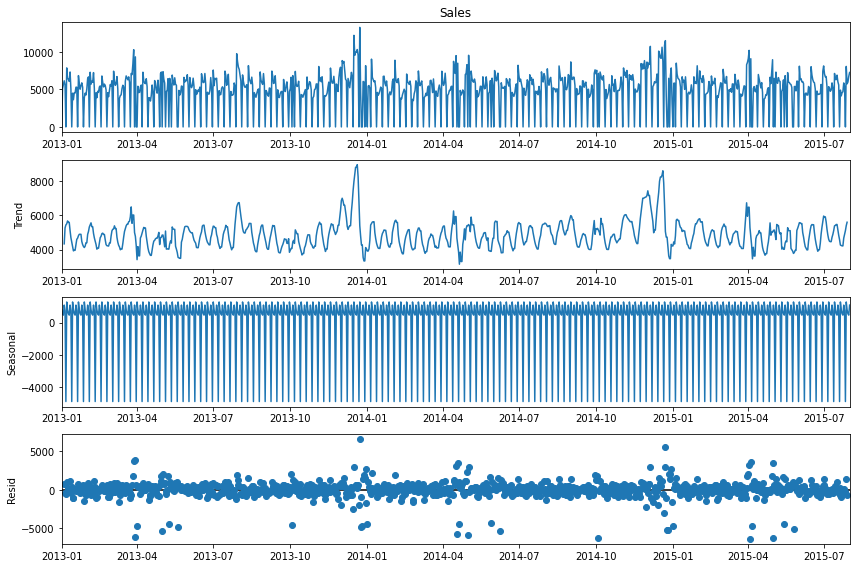

In [486]:
check_decomposition(sales_df_31['Sales'])

In [487]:
check_stationary(sales_df_31['Sales'])
check_stationary(sales_df_31['Customers'])

ADF Statistic: -4.884508
Critical Values @ 0.05: -2.86
p-value: 0.000037
Stationary result: True


ADF Statistic: -5.153967
Critical Values @ 0.05: -2.86
p-value: 0.000011
Stationary result: True




In [488]:
get_high_correlated(sales_df_31)

Sales                        1.000000
Customers                    0.976114
Open                         0.874272
Promo                        0.531911
DayOfWeek                    0.511494
StateHoliday                 0.283246
SchoolHoliday                0.126257
week                         0.096118
month                        0.094749
CompetitionOpenSince         0.036863
year                         0.001326
Store                             NaN
StoreType                         NaN
Assortment                        NaN
CompetitionDistance               NaN
CompetitionOpenSinceMonth         NaN
CompetitionOpenSinceYear          NaN
Promo2                            NaN
Promo2SinceWeek                   NaN
Promo2SinceYear                   NaN
PromoInterval                     NaN
PromoSince                        NaN
Name: Sales, dtype: float64

In [489]:
check_johansen(sales_df_31[['Sales','Customers']])

Checking for variables:  ['Sales' 'Customers']
   max_eig_stat  trace_stat
0    226.374237  341.374404
1    115.000167  115.000167 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

Rank:  2
All the variables are cointegrated


In [637]:
train_data, validation_data = split_data(sales_df_31)

shape of main df (942, 22)
shape of train (902, 22) Shape of validation (40, 22)


In [638]:
scaler = MinMaxScaler()
train_data[['Sales','Customers']] = scaler.fit_transform(train_data[['Sales','Customers']])
validation_data[['Sales','Customers']] = scaler.transform(validation_data[['Sales','Customers']])

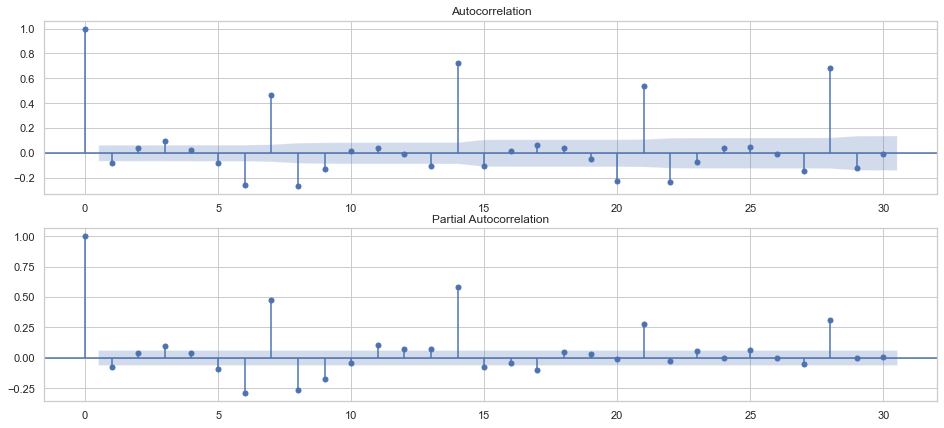

In [499]:
plt.figure(figsize=(16, 7))
plt.subplot(2,1,1)
plot_acf(sales_df_29['Sales'], ax=plt.gca(), lags = 30)
plt.subplot(2,1,2)
plot_pacf(sales_df_29['Sales'], ax=plt.gca(), lags = 30)
plt.show()

In [639]:
store_31_model = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_31_model.build_varmax_model(summary=True)
accuracy = store_31_model.print_accuracy()
model_comparison = add_model_accuracy("VARMAX('Open','DayOfWeek','Promo') model",accuracy,31)
model_comparison

VARMAX model builded successfully
                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  902
Model:                        VARMAX(7,7)   Log Likelihood                3438.997
Date:                    Sun, 20 Jun 2021   AIC                          -6747.995
Time:                            23:35:14   BIC                          -6435.695
Sample:                        01-01-2013   HQIC                         -6628.707
                             - 06-21-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            12.65, 3.74   Jarque-Bera (JB):     1306.00, 1673.90
Prob(Q):                        0.00, 0.05   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.56, 0.74   Skew:                      0.90, -0.40
Prob(H) (two-sided):            0.00, 0.01   Kurto

Store Number                                     Model Variable  RMSE  \
0           1.0                                    VARMAX    Sales  0.05   
0           1.0      VARMAX model-more exog(stateholiday)    Sales  0.05   
0           1.0     Simple VAR model('Sales','Customers')    Sales  0.10   
0           1.0                               ARIMA model    Sales  0.08   
0           1.0                              ARIMAX model    Sales  0.02   
0           1.0                              SARIMA model    Sales  0.09   
0           1.0                             SARIMAX model    Sales  0.02   
0           3.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.06   
0           3.0     Simple VAR model('Sales','Customers')    Sales  0.10   
0           3.0                               ARIMA model    Sales  0.10   
0           3.0                              ARIMAX model    Sales  0.05   
0           3.0                              SARIMA model    Sales  0.10   
0           3.0                             SARIMAX model    Sales  0.03   
0           8.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.11   
0           8.0     Simple VAR model('Sales','Customers')    Sales  0.12   
0           8.0                               ARIMA model    Sales  0.16   
0           8.0                              ARIMAX model    Sales  0.05   
0           8.0                              SARIMA model    Sales  0.14   
0           8.0                             SARIMAX model    Sales  0.04   
0           9.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.11   
0           9.0     Simple VAR model('Sales','Customers')    Sales  0.13   
0           9.0                               ARIMA model    Sales  0.12   
0           9.0                              ARIMAX model    Sales  0.04   
0           9.0                              SARIMA model    Sales  0.12   
0           9.0                             SARIMAX model    Sales  0.04   
0          25.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.05   
0          25.0     Simple VAR model('Sales','Customers')    Sales  0.08   
0          25.0                               ARIMA model    Sales  0.07   
0          25.0                              ARIMAX model    Sales  0.04   
0          25.0                              SARIMA model    Sales  0.07   
0          25.0                             SARIMAX model    Sales  0.04   
0          29.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.08   
0          29.0     Simple VAR model('Sales','Customers')    Sales  0.13   
0          29.0                               ARIMA model    Sales  0.12   
0          29.0                              ARIMAX model    Sales  0.03   
0          29.0                              SARIMA model    Sales  0.11   
0          29.0                             SARIMAX model    Sales  0.03   
0          31.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.06   

   sMAPE  R2 Score  Train MAPE  Validation MAPE  
0  33.08      0.93       11.32             9.79  
0  33.93      0.91       11.42            10.89  
0  41.56      0.64       13.51            16.64  
0  38.90      0.77       14.44            16.81  
0  28.79      0.98        4.31             4.26  
0  40.93      0.71       16.15            17.73  
0  28.45      0.99        4.25             3.96  
0  33.29      0.90       11.35             9.42  
0  43.78      0.68       16.08            18.80  
0  41.05      0.71       20.43            19.01  
0  33.38      0.94        4.83             9.02  
0  41.29      0.73       21.69            18.71  
0  30.31      0.97        5.09             5.92  
0  40.37      0.83       12.17            15.97  
0  39.34      0.79       13.27            14.88  
0  42.84      0.63       16.01            18.27  
0  31.55      0.96        5.74             7.20  
0  43.54      0.70       19.53            20.85  
0  29.45      0.98        5.60             5.00  
0  36.77      0.77       12.31        

In [670]:
store_31_model_var = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_31_model_var.build_var_model(summary=False)
accuracy = store_31_model_var.print_accuracy()
model_comparison = add_model_accuracy("Simple VAR model('Sales','Customers')",accuracy,31)

store_31_model_ar = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_31_model_ar.build_arima_model(summary=False)
accuracy = store_31_model_ar.print_accuracy()
model_comparison = add_model_accuracy("ARIMA model",accuracy,31)




VAR model builded successfully
Sales: RMSE: 0.21
Sales: Train MAPE: 8.75
Sales: Validation MAPE: 13.39
Sales: sMAPE: 37.79
Sales: R2 Score: 0.55
ARIMA model builded successfully
Sales: RMSE: 0.09
Sales: Train MAPE: 7.37
Sales: Validation MAPE: 7.21
Sales: sMAPE: 31.66
Sales: R2 Score: 0.92


In [669]:
store_31_model_sar = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_31_model_sar.build_sarima_model(summary=False)
accuracy = store_31_model_sar.print_accuracy()
model_comparison = add_model_accuracy("SARIMA model",accuracy,31)

store_31_model_sarx = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_31_model_sarx.build_sarimax_model(summary=False)
accuracy = store_31_model_sarx.print_accuracy()
model_comparison = add_model_accuracy("SARIMAX model",accuracy,31)

model_comparison[model_comparison['Store Number']==31.0]

SARIMA model builded successfully
Sales: RMSE: 0.1
Sales: Train MAPE: 8.11
Sales: Validation MAPE: 8.23
Sales: sMAPE: 32.72
Sales: R2 Score: 0.89
SARIMAX model builded successfully
Sales: RMSE: 0.02
Sales: Train MAPE: 0.73
Sales: Validation MAPE: 1.39
Sales: sMAPE: 26.24
Sales: R2 Score: 1.0


Store Number                                     Model Variable  RMSE  \
0          31.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.06   
0          31.0     Simple VAR model('Sales','Customers')    Sales  0.10   
0          31.0                               ARIMA model    Sales  0.08   
0          31.0                              SARIMA model    Sales  0.10   
0          31.0                             SARIMAX model    Sales  0.02   

   sMAPE  R2 Score  Train MAPE  Validation MAPE  
0  34.89      0.87       11.60            11.80  
0  41.84      0.61       13.95            17.00  
0  39.22      0.76       14.02            16.45  
0  32.72      0.89        8.11             8.23  
0  26.24      1.00        0.73             1.39

### Final Conclusion 
- we see that with variables Sales and Customer as endogeneous and 'Open','DayOfWeek','Promo' as exogeneous, the mape accuracy has turned out be good around 1.39 with SARIMAX Model again with less overfitting

# Store 46

In [698]:
sales_df_46 =sales_df_all[sales_df_all.Store==46]


In [699]:
pd.date_range(sales_df_46.index.min(),sales_df_46.index.max()).difference(sales_df_46.index)

DatetimeIndex(['2014-07-01', '2014-07-02', '2014-07-03', '2014-07-04',
               '2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-10',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', length=184, freq=None)

In [700]:
dt_range = pd.date_range(sales_df_46.index.min(),sales_df_46.index.max())
dt_range

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25',
               '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29',
               '2015-07-30', '2015-07-31'],
              dtype='datetime64[ns]', length=942, freq='D')

In [701]:
sales_df_46 = sales_df_46.reindex(dt_range)
sales_df_13.head()

Store  DayOfWeek     Sales  Customers  Open  Promo  StateHoliday  \
2013-01-01   13.0        2.0  0.000000   0.000000   0.0    0.0           1.0   
2013-01-02   13.0        3.0  8.226306   5.762051   1.0    0.0           0.0   
2013-01-03   13.0        4.0  8.209308   5.680173   1.0    0.0           0.0   
2013-01-04   13.0        5.0  8.255569   5.831882   1.0    0.0           0.0   
2013-01-05   13.0        6.0  8.363109   5.843544   1.0    0.0           0.0   

            SchoolHoliday  StoreType  Assortment  ...  \
2013-01-01            1.0        4.0         1.0  ...   
2013-01-02            1.0        4.0         1.0  ...   
2013-01-03            1.0        4.0         1.0  ...   
2013-01-04            1.0        4.0         1.0  ...   
2013-01-05            0.0        4.0         1.0  ...   

            CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  \
2013-01-01                       0.0     1.0             45.0   
2013-01-02                       0.0     1.0             45.0   
2013-01-03                       0.0     1.0             45.0   
2013-01-04                       0.0     1.0             45.0   
2013-01-05                       0.0     1.0             45.0   

            Promo2SinceYear  PromoInterval  year  month  week  \
2013-01-01           2009.0            2.0  2013      1     1   
2013-01-02           2009.0            2.0  2013      1     1   
2013-01-03           2009.0            2.0  2013      1     1   
2013-01-04           2009.0            2.0  2013      1     1   
2013-01-05           2009.0            2.0  2013      1     1   

            CompetitionOpenSince  PromoSince  
2013-01-01                   0.0        37.0  
2013-01-02                   0.0        37.0  
2013-01-03                   0.0        37.0  
2013-01-04                   0.0        37.0  
2013-01-05                   0.0        37.0  

[5 rows x 22 columns]

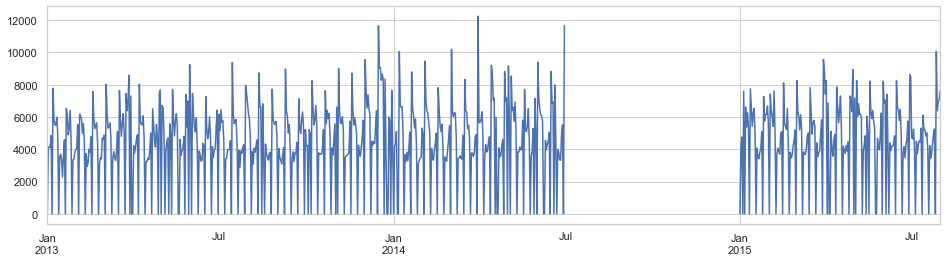

In [702]:
sales_df_46['Sales'].plot(figsize=(16,4))
plt.show()

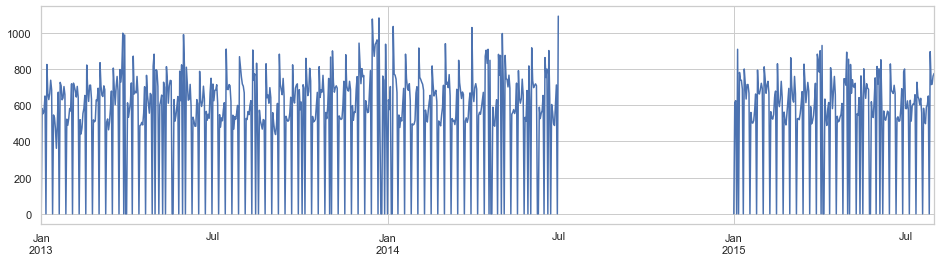

In [703]:
sales_df_46['Customers'].plot(figsize=(16,4))
plt.show()

### Observation 
- we see that the series is missing between July 2014 and Jan 2015
- lets interpolate the missing dates

In [704]:
sales_df_46['year'] = sales_df_46.index.year
sales_df_46['month'] = sales_df_46.index.month
sales_df_46['week'] = sales_df_46.index.week

In [705]:
sales_df_46['DayOfWeek'].loc[sales_df_46['DayOfWeek'].isnull()] = sales_df_46[sales_df_46['DayOfWeek'].isnull()].index.day_of_week+1

In [706]:
#sales_df_13.loc[(sales_df_13['DayOfWeek']==7.0) & (sales_df_13['Sales'].isnull()),'Sales'] = 0
#sales_df_13.loc[(sales_df_13['DayOfWeek']==7.0) & (sales_df_13['Customers'].isnull()),'Customers'] = 0

In [707]:
sales_df_46.loc[(sales_df_46['DayOfWeek']==7.0) & (sales_df_46['Open'].isnull()),'Open'] = 0

In [708]:
sales_df_46.loc[(sales_df_46['Open'].isnull()),'Open'] = 1

In [709]:
sales_df_46['Store'].fillna(46,inplace=True)

In [710]:
sales_df_46.isnull().sum()

Store                          0
DayOfWeek                      0
Sales                        184
Customers                    184
Open                           0
Promo                        184
StateHoliday                 184
SchoolHoliday                184
StoreType                    184
Assortment                   184
CompetitionDistance          184
CompetitionOpenSinceMonth    184
CompetitionOpenSinceYear     184
Promo2                       184
Promo2SinceWeek              184
Promo2SinceYear              184
PromoInterval                184
year                           0
month                          0
week                           0
CompetitionOpenSince         184
PromoSince                   184
dtype: int64

### interpolate missing series

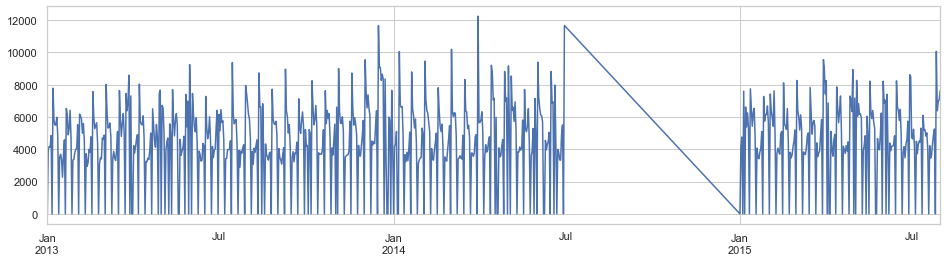

In [711]:
sales_df_46['Sales'].interpolate(method='time').plot(figsize=(16,4))
plt.show()

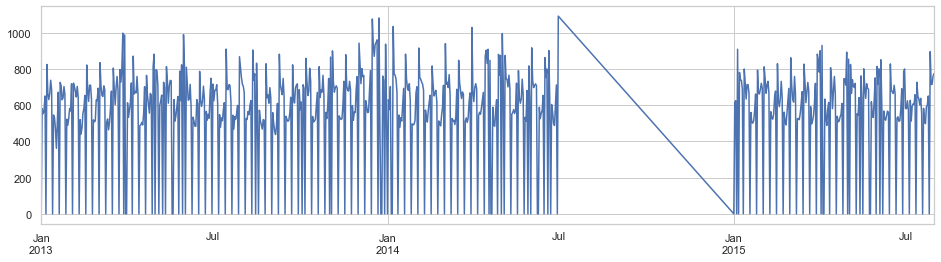

In [712]:
sales_df_46['Customers'].interpolate(method='time').plot(figsize=(16,4))
plt.show()

In [713]:
sales_df_46 = sales_df_46.interpolate(method='time')
sales_df_46.isnull().sum()

Store                        0
DayOfWeek                    0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
year                         0
month                        0
week                         0
CompetitionOpenSince         0
PromoSince                   0
dtype: int64

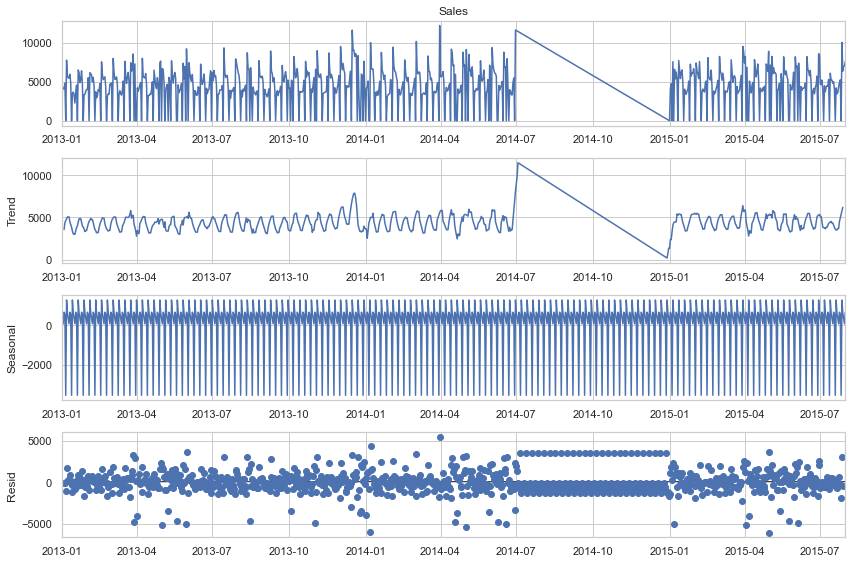

In [714]:
check_decomposition(sales_df_46['Sales'])

In [715]:
check_stationary(sales_df_46['Sales'])
check_stationary(sales_df_46['Customers'])

ADF Statistic: -2.856999
Critical Values @ 0.05: -2.86
p-value: 0.050582
Stationary result: False


ADF Statistic: -2.949292
Critical Values @ 0.05: -2.86
p-value: 0.039909
Stationary result: True




### Observation
- since the sales data is not stationary, we need to convert them to stationary
- we see that there are some outliers after linear interpolation which is leading to data being non stationary, hence lets impute the outliers with linear interpolation

In [717]:
sales_df_46['Sales'] = interpolate_outlier(sales_df_46['Sales'])
check_stationary(sales_df_46['Sales'])

ADF Statistic: -3.357315
Critical Values @ 0.05: -2.86
p-value: 0.012503
Stationary result: True




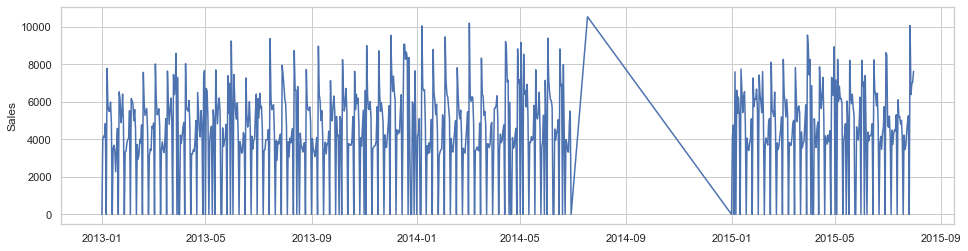

In [718]:
plt.figure(figsize=(16,4))
sns.lineplot(data=sales_df_46['Sales'])
plt.show()

### observation
- we see that series has become stationary now

In [693]:
get_high_correlated(sales_df_46)

Sales                        1.000000
Open                         0.893035
Customers                    0.864622
DayOfWeek                    0.456044
Promo                        0.361871
StateHoliday                 0.237370
week                         0.084324
SchoolHoliday                0.081267
month                        0.066141
PromoSince                   0.047944
CompetitionOpenSince         0.041939
year                         0.018746
Store                             NaN
StoreType                         NaN
Assortment                        NaN
CompetitionDistance               NaN
CompetitionOpenSinceMonth         NaN
CompetitionOpenSinceYear          NaN
Promo2                            NaN
Promo2SinceWeek                   NaN
Promo2SinceYear                   NaN
PromoInterval                     NaN
Name: Sales, dtype: float64

In [694]:
check_johansen(sales_df_46[['Sales','Customers']])

Checking for variables:  ['Sales' 'Customers']
   max_eig_stat  trace_stat
0    126.836363  175.356819
1     48.520456   48.520456 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

Rank:  2
All the variables are cointegrated


In [719]:
train_data, validation_data = split_data(sales_df_46)

shape of main df (942, 22)
shape of train (902, 22) Shape of validation (40, 22)


In [720]:
scaler = MinMaxScaler()
train_data[['Sales','Customers']] = scaler.fit_transform(train_data[['Sales','Customers']])
validation_data[['Sales','Customers']] = scaler.transform(validation_data[['Sales','Customers']])

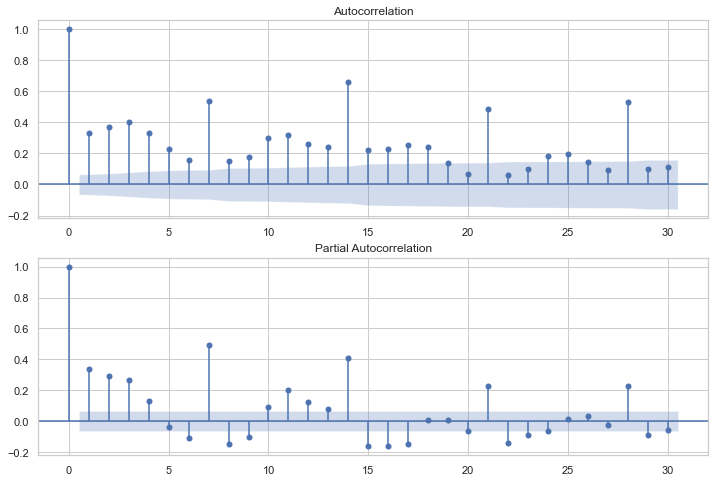

In [721]:

plt.subplot(2,1,1)
plot_acf(sales_df_46['Sales'], ax=plt.gca(), lags = 30)
plt.subplot(2,1,2)
plot_pacf(sales_df_46['Sales'], ax=plt.gca(), lags = 30)
plt.show()

In [722]:
store_46_model = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_46_model.build_varmax_model(summary=True)
accuracy = store_46_model.print_accuracy()
model_comparison = add_model_accuracy("VARMAX('Open','DayOfWeek','Promo') model",accuracy,46)
model_comparison

VARMAX model builded successfully
                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  902
Model:                        VARMAX(7,7)   Log Likelihood                2023.370
Date:                    Mon, 21 Jun 2021   AIC                          -3916.740
Time:                            12:31:19   BIC                          -3604.440
Sample:                        01-01-2013   HQIC                         -3797.452
                             - 06-21-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             8.10, 0.44   Jarque-Bera (JB):    437.49, 121920.61
Prob(Q):                        0.00, 0.51   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.63, 1.27   Skew:                      -0.27, 4.36
Prob(H) (two-sided):            0.00, 0.04   Kurto

Store Number                                     Model Variable  RMSE  \
0           1.0                                    VARMAX    Sales  0.05   
0           1.0      VARMAX model-more exog(stateholiday)    Sales  0.05   
0           1.0     Simple VAR model('Sales','Customers')    Sales  0.10   
0           1.0                               ARIMA model    Sales  0.08   
0           1.0                              ARIMAX model    Sales  0.02   
0           1.0                              SARIMA model    Sales  0.09   
0           1.0                             SARIMAX model    Sales  0.02   
0           3.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.06   
0           3.0     Simple VAR model('Sales','Customers')    Sales  0.10   
0           3.0                               ARIMA model    Sales  0.10   
0           3.0                              ARIMAX model    Sales  0.05   
0           3.0                              SARIMA model    Sales  0.10   
0           3.0                             SARIMAX model    Sales  0.03   
0           8.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.11   
0           8.0     Simple VAR model('Sales','Customers')    Sales  0.12   
0           8.0                               ARIMA model    Sales  0.16   
0           8.0                              ARIMAX model    Sales  0.05   
0           8.0                              SARIMA model    Sales  0.14   
0           8.0                             SARIMAX model    Sales  0.04   
0           9.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.11   
0           9.0     Simple VAR model('Sales','Customers')    Sales  0.13   
0           9.0                               ARIMA model    Sales  0.12   
0           9.0                              ARIMAX model    Sales  0.04   
0           9.0                              SARIMA model    Sales  0.12   
0           9.0                             SARIMAX model    Sales  0.04   
0          25.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.05   
0          25.0     Simple VAR model('Sales','Customers')    Sales  0.08   
0          25.0                               ARIMA model    Sales  0.07   
0          25.0                              ARIMAX model    Sales  0.04   
0          25.0                              SARIMA model    Sales  0.07   
0          25.0                             SARIMAX model    Sales  0.04   
0          29.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.08   
0          29.0     Simple VAR model('Sales','Customers')    Sales  0.13   
0          29.0                               ARIMA model    Sales  0.12   
0          29.0                              ARIMAX model    Sales  0.03   
0          29.0                              SARIMA model    Sales  0.11   
0          29.0                             SARIMAX model    Sales  0.03   
0          31.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.06   
0          31.0     Simple VAR model('Sales','Customers')    Sales  0.10   
0          31.0                               ARIMA model    Sales  0.08   
0          13.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.10   
0          13.0     Simple VAR model('Sales','Customers')    Sales  0.21   
0          13.0                               ARIMA model    Sales  0.09   
0          13.0                              ARIMAX model    Sales  0.02   
0          13.0                              SARIMA model    Sales  0.10   
0          13.0                             SARIMAX model    Sales  0.02   
0          31.0                              SARIMA model    Sales  0.10   
0          31.0                             SARIMAX model    Sales  0.02   
0          31.0     Simple VAR model('Sales','Customers')    Sales  0.21   
0          31.0                               ARIMA model    Sales  0.09   
0          46.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.10   

   sMAPE  R2 Score  Train MAPE  Validation MAPE  


In [723]:
store_46_model_var = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_46_model_var.build_var_model(summary=False)
accuracy = store_46_model_var.print_accuracy()
model_comparison = add_model_accuracy("Simple VAR model('Sales','Customers')",accuracy,46)

store_46_model_ar = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_46_model_ar.build_arima_model(summary=False)
accuracy = store_46_model_ar.print_accuracy()
model_comparison = add_model_accuracy("ARIMA model",accuracy,46)

store_46_model_arx = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_46_model_arx.build_arimax_model(summary=False)
accuracy = store_46_model_arx.print_accuracy()
model_comparison = add_model_accuracy("ARIMAX model",accuracy,46)

store_46_model_sar = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_46_model_sar.build_sarima_model(summary=False)
accuracy = store_46_model_sar.print_accuracy()
model_comparison = add_model_accuracy("SARIMA model",accuracy,46)

store_46_model_sarx = Model(7,7,endo_vars=['Sales','Customers'],exog_vars=['Open','DayOfWeek','Promo'])
store_46_model_sarx.build_sarimax_model(summary=False)
accuracy = store_46_model_sarx.print_accuracy()
model_comparison = add_model_accuracy("SARIMAX model",accuracy,46)

model_comparison[model_comparison['Store Number']==46.0]


VAR model builded successfully
Sales: RMSE: 0.14
Sales: Train MAPE: 21.23
Sales: Validation MAPE: 23.84
Sales: sMAPE: 45.87
Sales: R2 Score: 0.56
ARIMA model builded successfully
Sales: RMSE: 0.14
Sales: Train MAPE: 28.27
Sales: Validation MAPE: 22.32
Sales: sMAPE: 43.68
Sales: R2 Score: 0.59
ARIMAX model builded successfully
Sales: RMSE: 0.06
Sales: Train MAPE: 9.2
Sales: Validation MAPE: 8.57
Sales: sMAPE: 32.52
Sales: R2 Score: 0.93
SARIMA model builded successfully
Sales: RMSE: 0.14
Sales: Train MAPE: 23.67
Sales: Validation MAPE: 24.64
Sales: sMAPE: 45.02
Sales: R2 Score: 0.56
SARIMAX model builded successfully
Sales: RMSE: 0.05
Sales: Train MAPE: 9.02
Sales: Validation MAPE: 8.45
Sales: sMAPE: 32.35
Sales: R2 Score: 0.94


Store Number                                     Model Variable  RMSE  \
0          46.0  VARMAX('Open','DayOfWeek','Promo') model    Sales  0.10   
0          46.0     Simple VAR model('Sales','Customers')    Sales  0.14   
0          46.0                               ARIMA model    Sales  0.14   
0          46.0                              ARIMAX model    Sales  0.06   
0          46.0                              SARIMA model    Sales  0.14   
0          46.0                             SARIMAX model    Sales  0.05   

   sMAPE  R2 Score  Train MAPE  Validation MAPE  
0  39.54      0.79       30.01            16.86  
0  45.87      0.56       21.23            23.84  
0  43.68      0.59       28.27            22.32  
0  32.52      0.93        9.20             8.57  
0  45.02      0.56       23.67            24.64  
0  32.35      0.94        9.02             8.45

### Final Conclusion 
- we see that with variables Sales and Customer as endogeneous and 'Open','DayOfWeek','Promo' as exogeneous, the mape accuracy has turned out be good around 8.45 with SARIMAX Model again with less overfitting

# Conclusion 

- we saw that with help of correlation we are able to decide which variables can be used as endogeneous and exogeneous variables
- hence we decided Customers as endog and promo, open and Day of week as exog
- With help of johansan test, we were able to decide if variables are cointegrated. 
- Also, we saw that customers had direct relationship with sales and it was mutual
- With help of boxplots, we were able to decide the different categorical variables like promo, promo2 , holiday , Open were related to sales
- with help of PACF And ACF we were able to decide p and q values. 
- we also treated outliers with linear interpolation as we could not remove them as time series consistency would be lost, which resulted in good accuracy.  
- Then we tried out with different models such ARIMA, ARIMAX, SARIMA, SARIMAX,VAR,VARMAX for each store that were important for company and figured out which models suits the best
- We evaluated the model with MAPE and RMSE, and decided which model to forecast sales. 
- then we forecast sales for next 6 weeks and check the validation mape which resulted out good and less than 10. Also the train and validation accuracy were close, which says that there were no overfitting  